# Homework 1. Which of two things is larger?

Due: Thursday, September 19, 11:59 PM

<a href=https://raw.github.com/cs109/content/master/HW1.ipynb download=HW1.ipynb> Download this assignment</a>

---

Useful libraries for this assignment

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting
* [requests](http://docs.python-requests.org/en/latest/), for downloading web content
* [pattern](http://www.clips.ua.ac.be/pages/pattern), for parsing html and xml pages
* [fnmatch](http://docs.python.org/2/library/fnmatch.html) (optional), for Unix-style string matching

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
#from pattern import web
from bs4 import BeautifulSoup
from IPython.core.display import HTML
# set some nicer defaults for matplotlib
from matplotlib import rcParams
from cycler import cycler

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.prop_cycle'] = cycler('color',dark2_colors)#color_cycle is deprecated
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

## Introduction

This was the [XKCD comic](http://xkcd.com/1131/) after the 2012 Presidential election:

<img src="http://imgs.xkcd.com/comics/math.png">

The comic refers to the fact that Nate Silver's statistical model (which is based mostly on combining information from pre-election polls) correctly predicted the outcome of the 2012 presidential race in all 50 states. 

Polling data isn't a perfect predictor for the future, and some polls are more accurate than others. This means that election forecastors must consider prediction uncertainty when building models.

In this first assignment, you will perform a simple analysis of polling data about the upcoming <a href="http://en.wikipedia.org/wiki/Governor_(United_States)">Governor races</a>. The assignment has three main parts:

**First** you will build some tools to download historical polling data from the web, and parse it into a more convenient format. 

**Next** you will use these tools to aggregate and visualize several past Governor races

**Finally** you will run a bootstrap analysis to estimate the probable outcome of current Governor races, given the level of precision of historical polls.

---



## Part 1: Collect and Clean

The [Real Clear Politics](http://www.realclearpolitics.com) website archives many political polls. In addition, they combine related polls to form an "RCP average" estimate of public opinion over time. For example, the chart on [this page](http://www.realclearpolitics.com/epolls/2012/president/us/general_election_romney_vs_obama-1171.html) shows historical polling data for the Obama-Romney presidential race. The chart is an average of the polling data table below the chart.

The data used to generate plots like this are stored as XML pages, with URLs like:

http://charts.realclearpolitics.com/charts/[id].xml

Here, [id] is a unique integer, found at the end of the URL of the page that displays the graph. The id for the Obama-Romney race is 1171:

http://charts.realclearpolitics.com/charts/1171.xml

Opening this page in Google Chrome or Firefox will show you the XML content in an easy-to-read format. Notice that XML tags are nested inside each other, hierarchically (the jargony term for this is the "Document Object Model", or "DOM"). The first step of webscraping is almost always exploring the HTML/XML source in a browser, and getting a sense of this hierarchy.

---

#### Problem 0

The above XML page includes 5 distinct tags (one, for example, is `chart`). List these tags, and depict how they nest inside each other using an indented list. For example:

* Page
  * Section
     * Paragraph
  * Conclusion

*Your Answer Here*
* chart
   * series
      * value
   * graphs
      * graph
         * value

---
#### Problem 1

We want to download and work with poll data like this. Like most programming tasks, we will break this into many smaller, easier pieces

Fill in the code for the `get_poll_xml` function, that finds and downloads an XML page discussed above

**Hint** 

`requests.get("http://www.google.com").text` downloads the text from Google's homepage

In [2]:
"""
Function
--------
get_poll_xml

Given a poll_id, return the XML data as a text string

Inputs
------
poll_id : int
    The ID of the poll to fetch

Returns
-------
xml : str
    The text of the XML page for that poll_id

Example
-------
>>> get_poll_xml(1044)
u'<?xml version="1.0" encoding="UTF-8"?><chart><series><value xid=\'0\'>1/27/2009</value>
...etc...
"""    
#your code here    
def get_poll_xml(id):
    return(requests.get("http://charts.realclearpolitics.com/charts/%d.xml"%id).text)
get_poll_xml(1044)

'<?xml version="1.0" encoding="UTF-8"?><chart><series><value xid=\'0\'>1/27/2009</value><value xid=\'1\'>1/28/2009</value><value xid=\'2\'>1/29/2009</value><value xid=\'3\'>1/30/2009</value><value xid=\'4\'>1/31/2009</value><value xid=\'5\'>2/01/2009</value><value xid=\'6\'>2/02/2009</value><value xid=\'7\'>2/03/2009</value><value xid=\'8\'>2/04/2009</value><value xid=\'9\'>2/05/2009</value><value xid=\'10\'>2/06/2009</value><value xid=\'11\'>2/07/2009</value><value xid=\'12\'>2/08/2009</value><value xid=\'13\'>2/09/2009</value><value xid=\'14\'>2/10/2009</value><value xid=\'15\'>2/11/2009</value><value xid=\'16\'>2/12/2009</value><value xid=\'17\'>2/13/2009</value><value xid=\'18\'>2/14/2009</value><value xid=\'19\'>2/15/2009</value><value xid=\'20\'>2/16/2009</value><value xid=\'21\'>2/17/2009</value><value xid=\'22\'>2/18/2009</value><value xid=\'23\'>2/19/2009</value><value xid=\'24\'>2/20/2009</value><value xid=\'25\'>2/21/2009</value><value xid=\'26\'>2/22/2009</value><value xid=

Here are some other functions we'll use later. `plot_colors` contains hints about parsing XML data.

In [3]:
# "r"egular "e"xpressions is kind of a mini-language to
# do pattern matching on text
import re

def _strip(s):
    """This function removes non-letter characters from a word
    
    for example _strip('Hi there!') == 'Hi there'
    """
    return re.sub(r'[\W_]+', '', s)

def plot_colors(xml):
    """
    Given an XML document like the link above, returns a python dictionary
    that maps a graph title to a graph color.
    
    Both the title and color are parsed from attributes of the <graph> tag:
    <graph title="the title", color="#ff0000"> -> {'the title': '#ff0000'}
    
    These colors are in "hex string" format. This page explains them:
    http://coding.smashingmagazine.com/2012/10/04/the-code-side-of-color/
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    #dom = web.Element(xml)
    dom = BeautifulSoup(xml,'xml')#should i use html.parser, lxml or xml for better performance
    result = {}
    #for graph in dom.by_tag('graph'):
    for graph in dom.find_all('graph'):
        title = _strip(graph['title'])
        result[title] = graph['color']
    return result
plot_colors(get_poll_xml(1121))

{'Ehrlich': '#D30015', 'OMalley': '#3B5998'}

---

#### Problem 2

Even though `get_poll_xml` pulls data from the web into Python, it does so as a block of text. This still isn't very useful. (Use the `web` module in `pattern` to parse this text, and extract data into a pandas DataFrame.), using bs4.BeatifulSoup instead of web

**Hints**

* You might want create python lists for each column in the XML. Then, to turn these lists into a DataFrame, run

`pd.DataFrame({'column_label_1': list_1, 'column_label_2':list_2, ...})`

* use the pandas function `pd.to_datetime` to convert strings into dates

In [4]:
#your code here
def rcp_poll_data(xml):
    """
    Function
    ---------
    rcp_poll_data

    Extract poll information from an XML string, and convert to a DataFrame

    Parameters
    ----------
    xml : str
        A string, containing the XML data from a page like 
        get_poll_xml(1044)
        
    Returns
    -------
    A pandas DataFrame with the following columns:
        date: The date for each entry
        title_n: The data value for the gid=n graph (take the column name from the `title` tag)
        
    This DataFrame should be sorted by date
        
    Example
    -------
    Consider the following simple xml page:
    
    <chart>
    <series>
    <value xid="0">1/27/2009</value>
    <value xid="1">1/28/2009</value>
    </series>
    <graphs>
    <graph gid="1" color="#000000" balloon_color="#000000" title="Approve">
    <value xid="0">63.3</value>
    <value xid="1">63.3</value>
    </graph>
    <graph gid="2" color="#FF0000" balloon_color="#FF0000" title="Disapprove">
    <value xid="0">20.0</value>
    <value xid="1">20.0</value>
    </graph>
    </graphs>
    </chart>
    
    Given this string, rcp_poll_data should return
    result = pd.DataFrame({'date': pd.to_datetime(['1/27/2009', '1/28/2009']), 
                           'Approve': [63.3, 63.3], 'Disapprove': [20.0, 20.0]})
"""
    dom = BeautifulSoup(xml,'xml')
    answer = {}
    answer['date'] = [value.getText() for value in dom.find('series').find_all('value')]
    #{graph['title']:val.getText() for graph in dom.find_all('graph') for val in graph.find_all('value')
    for graph in dom.find_all('graph'):
        answer[_strip(graph['title'])] = [value.getText() for value in graph.find_all('value')]
    answer = pd.DataFrame(answer)
    answer[[c for c in answer.columns if c is not 'date']] = answer[[c for c in answer.columns if c is not 'date']].apply(pd.to_numeric)
    answer[['date']] = answer[['date']].apply(pd.to_datetime)
    return answer
df1044 = rcp_poll_data(get_poll_xml(1121))

In [5]:
pd.DataFrame?

In [10]:
print(df1044.shape)
df1044_clean = df1044.dropna()
df1044_clean.shape
df1044_clean.dtypes
#df1044[['Approve','Disapprove']] = df1044[['Approve','Disapprove']].apply(pd.to_numeric)
df1044.dtypes
df1044[['Ehrlich','OMalley']].sum(axis=1)

(225, 3)


0      88.7
1      88.7
2      88.7
3      88.7
4      88.7
5      88.7
6      88.7
7      88.7
8      88.7
9      88.7
10     88.7
11     88.7
12     88.7
13     88.7
14     88.7
15     88.7
16     88.7
17     88.7
18     88.7
19     88.7
20     88.7
21     88.7
22     88.7
23     88.7
24     88.3
25     88.3
26     88.3
27     88.3
28     88.3
29     88.3
       ... 
195    90.3
196    90.3
197    90.3
198    90.3
199    90.3
200    90.3
201    90.3
202    90.3
203    90.6
204    90.6
205    90.6
206    90.6
207    90.6
208    89.6
209    91.8
210    91.8
211    91.8
212    91.8
213    91.8
214    91.8
215    91.8
216    91.8
217    91.8
218     0.0
219     0.0
220     0.0
221     0.0
222     0.0
223     0.0
224     0.0
Length: 225, dtype: float64

The output from `rcp_poll_data` is much more useful for analysis. For example, we can plot with it:

In [11]:
def poll_plot(poll_id):
    """
    Make a plot of an RCP Poll over time
    
    Parameters
    ----------
    poll_id : int
        An RCP poll identifier
    """

    # hey, you wrote two of these functions. Thanks for that!
    xml = get_poll_xml(poll_id)
    data = rcp_poll_data(xml)
    colors = plot_colors(xml)

    #remove characters like apostrophes
    data = data.rename(columns = {c: _strip(c) for c in data.columns})

    #normalize poll numbers so they add to 100%    
    #data[[i for i in colors.keys()]] = data[[i for i in colors.keys()]].apply(pd.to_numeric)
    #data[['date']] = data[['date']].apply(pd.to_datetime)
    norm = data[[i for i in colors.keys()]].sum(axis=1)/100
    for c in colors.keys():
        data[c] /= norm
    #
    for label, color in colors.items():
        plt.plot(data.date, data[label], color=color, label=label)        
        
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")

If you've done everything right so far, the following code should reproduce the graph on [this page](http://www.realclearpolitics.com/epolls/other/president_obama_job_approval-1044.html)

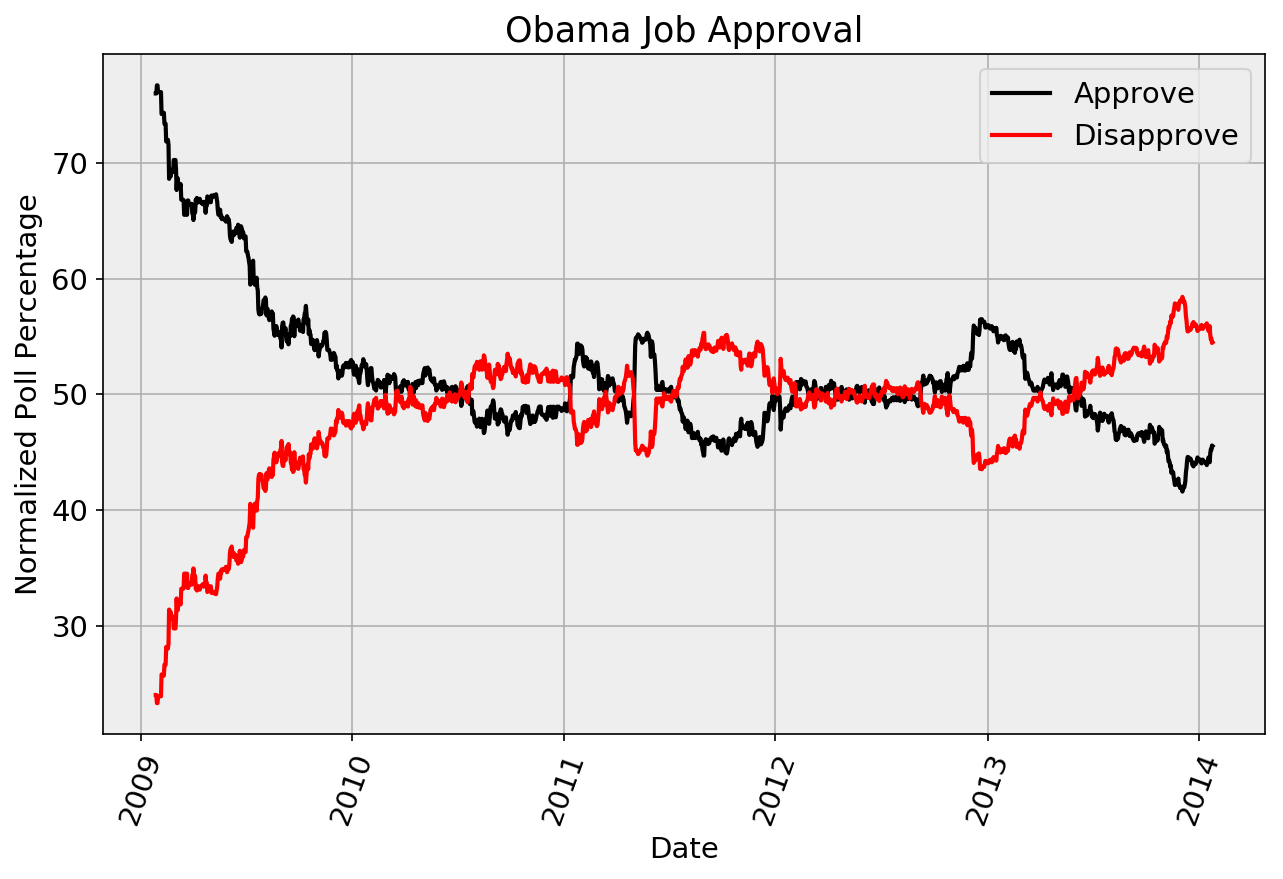

In [12]:
poll_plot(1044)
plt.title("Obama Job Approval")

---

## Part 2: Aggregate and Visualize


#### Problem 3

Unfortunately, these data don't have any error bars. If a candidate leads by 10% in the RCP average, is she a shoo-in to win? Or is this number too close to call? Does a 10% poll lead mean more 1 day before a race than it does 1 week before? Without error estimates, these questions are impossible to answer.

To get a sense of how accurate the RCP polls are, you will gather data from many previous Governor races, where the outcome is known.

This url has links to many governer races. 

http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html

Notice that each link to a governor race has the following URL pattern:

http://www.realclearpolitics.com/epolls/[YEAR]/governor/[STATE]/[TITLE]-[ID].html


Write a function that scans html for links to URLs like this

**Hint** The [fnmatch](http://docs.python.org/2/library/fnmatch.html) function is useful for simple string matching tasks.

In [13]:
#your code here
def is_gov_race(l):
    """return True if a URL refers to a Governor race"""    
    pattern = '*/epolls/????/governor/??/*-*.html'
    return fnmatch(l, pattern)
def get_link(l):
    pattern = '/epolls/????/governor/??/*-*.html'
    if fnmatch(l,pattern):
        l = "http://www.realclearpolitics.com"+l
    return l
def find_governor_races(htmlText):
    """
    Function
    --------
    find_governor_races

    Find and return links to RCP races on a page like
    http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html
    
    Parameters
    ----------
    html : str
        The HTML content of a page to scan
        
    Returns
    -------
    A list of urls for Governer race pages
    
    Example
    -------
    For a page like
    
    <html>
    <body>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html"></a>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html"></a>
    </body>
    </html>
    
    find_governor_races would return
    ['http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html',
     'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html']
"""
    soup = BeautifulSoup(htmlText,'html.parser')
    return([get_link(link['href']) for link in soup.find_all('a') if link.has_attr('href') and is_gov_race(link['href']) ])

In [14]:
find_governor_races(requests.get('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html').text)
#find_governer_races(page)

['http://www.realclearpolitics.com/epolls/2009/governor/va/virginia_governor_mcdonnell_vs_deeds-1055.html',
 'http://www.realclearpolitics.com/epolls/2009/governor/nj/new_jersey_governor_corzine_vs_christie-1051.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/co/colorado_governor_maes_vs_hickenlooper_vs_tancredo-1677.html',
 'http://www.realclearpolitics.com/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html',
 'http://www.r

#### Problem 4

At this point, you have functions to find a collection of governor races, download historical polling data from each one,
parse them into a numerical DataFrame, and plot this data.

The main question we have about these data are how accurately they predict election outcomes. To answer this question, we
need to grab the election outcome data.

Write a function that looks up and returns the election result on a page like [this one](http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html). 

**Remember to look at the HTML source!**

You can do this by selection `view->developer->view source` in Chrome, or `Tools -> web developer -> page source` in Firefox. Altenatively, you can right-click on a part of the page, and select "inspect element"

In [24]:
#your code here#
def race_result(url):
    """
    Function
    --------
    race_result

    Return the actual voting results on a race page
    
    Parameters
    ----------
    url : string
        The website to search through
        
    Returns
    -------
    A dictionary whose keys are candidate names,
    and whose values is the percentage of votes they received.
    
    If necessary, normalize these numbers so that they add up to 100%.
    
    Example
    --------
    >>> url = 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html'
    >>> race_result(url)
    {'Brown': 56.0126582278481, 'Whitman': 43.9873417721519}
    """
    soup = BeautifulSoup(requests.get(url).text,'html.parser')
    table = soup.find_all('table','data')[0]
    data = [td.getText() for td in table.find('tr','final').find_all('td') ]
    data = [float(value) for value in data[3:-1]]
    data = (data/np.sum(data))*100
    labels = [th.getText() for th in table.find_all('th')]
    labels = [label.split()[0] for label in labels[3:-1]]
    return {_strip(l):r for l,r in zip(labels,data)}
url = 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html'
#HTML(str(race_result(url)[0]))
race_result(url)

{'Brown': 56.0126582278481, 'Whitman': 43.987341772151893}

Here are some more utility functions that take advantage of what you've done so far.

In [16]:
def id_from_url(url):
    """Given a URL, look up the RCP identifier number"""
    return int(url.split('-')[-1].split('.html')[0])


def plot_race(url):
    """Make a plot summarizing a senate race
    
    Overplots the actual race results as dashed horizontal lines
    """
    #hey, thanks again for these functions!
    id = id_from_url(url)
    xml = get_poll_xml(id)    
    colors = plot_colors(xml)

    if len(colors) == 0:
        return
    
    #really, you shouldn't have
    result = race_result(url)
    
    poll_plot(id)
    plt.xlabel("Date")
    plt.ylabel("Polling Percentage")
    for r in result:
        plt.axhline(result[r], color=colors[_strip(r)], alpha=0.6, ls='--')


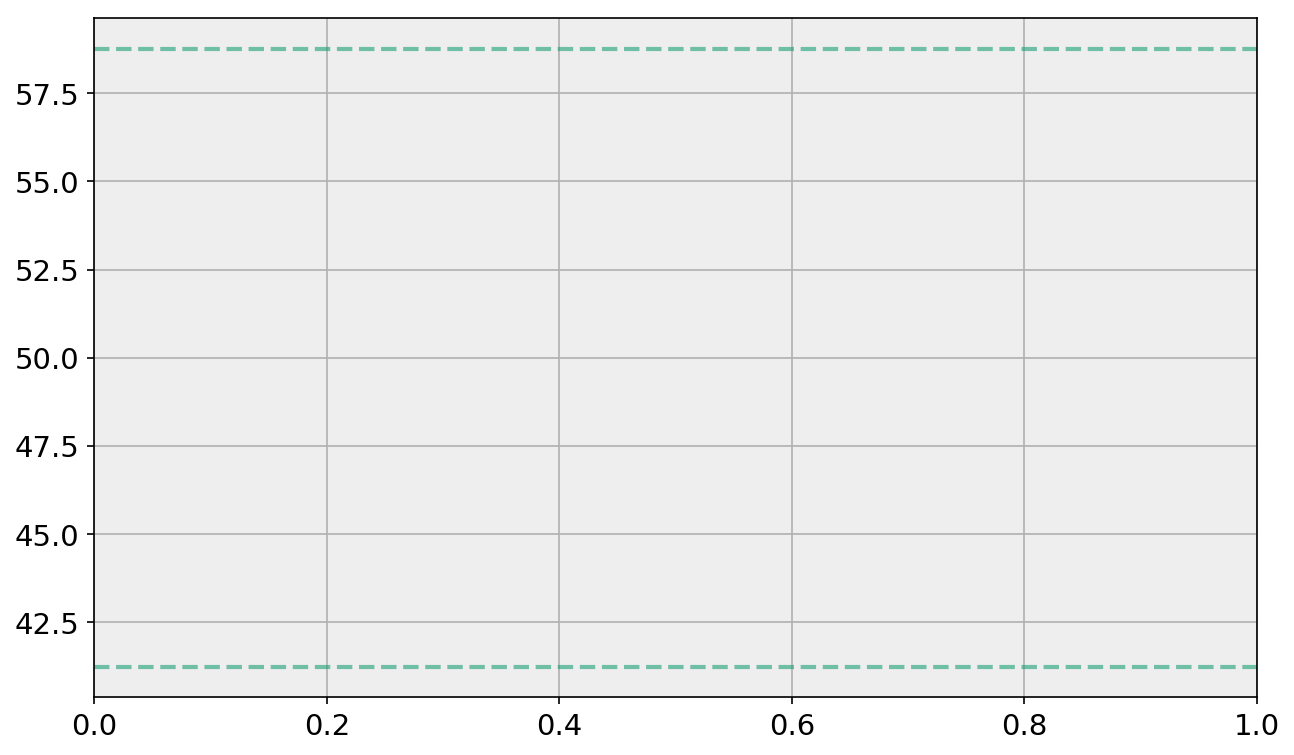

In [25]:
id = id_from_url('https://www.realclearpolitics.com/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html')
xml = get_poll_xml(id)
colors = plot_colors(xml)
colors
result = race_result('http://www.realclearpolitics.com/epolls/2009/governor/va/virginia_governor_mcdonnell_vs_deeds-1055.html')
result
for r in result:
        plt.axhline(result[r], alpha=0.6, ls='--')

Now that this is done, we can easily visualize many historical Governer races. The solid line plots the poll history, the dotted line reports the actual result.

If this code block fails, you probably have a bug in one of your functions.

http://www.realclearpolitics.com/epolls/2009/governor/va/virginia_governor_mcdonnell_vs_deeds-1055.html


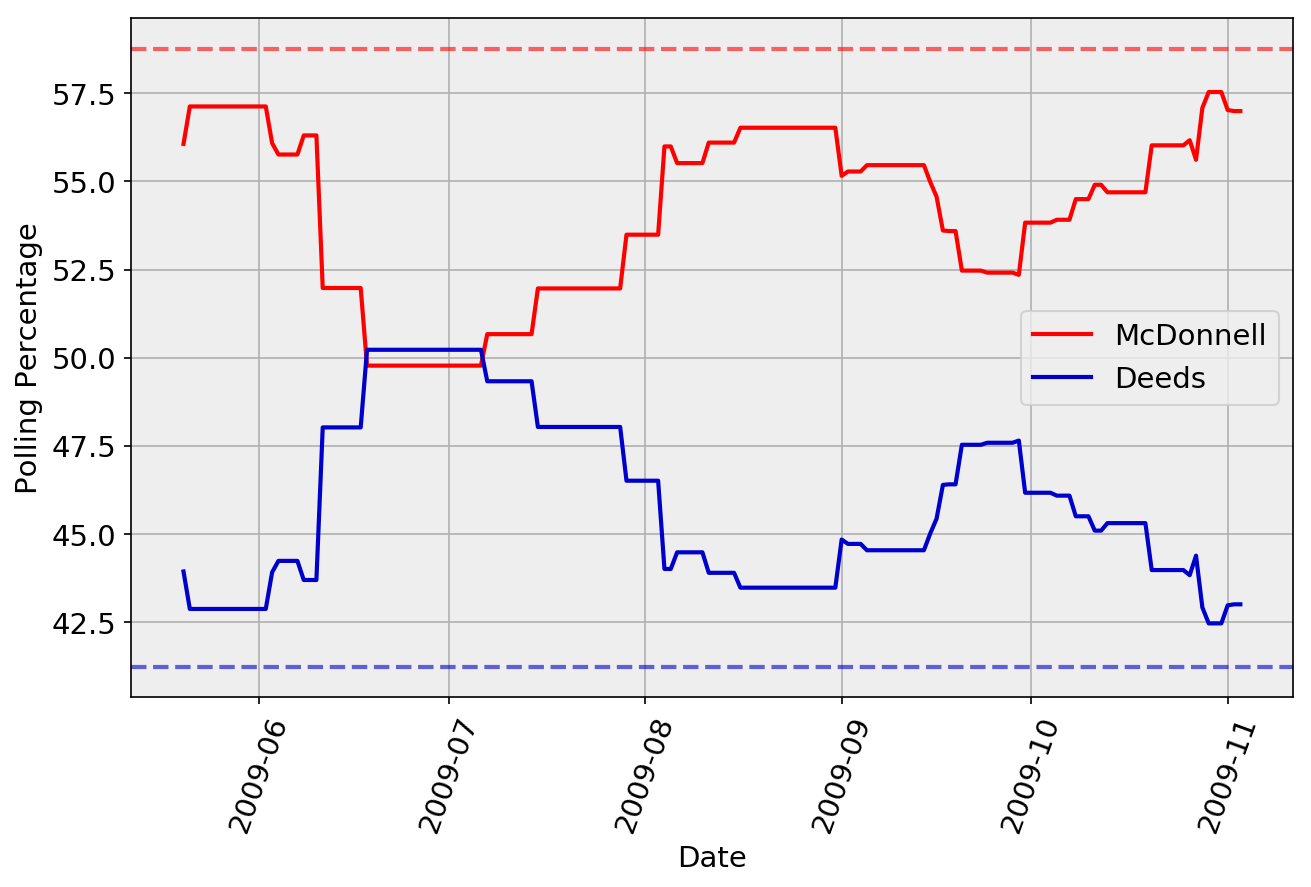

http://www.realclearpolitics.com/epolls/2009/governor/nj/new_jersey_governor_corzine_vs_christie-1051.html


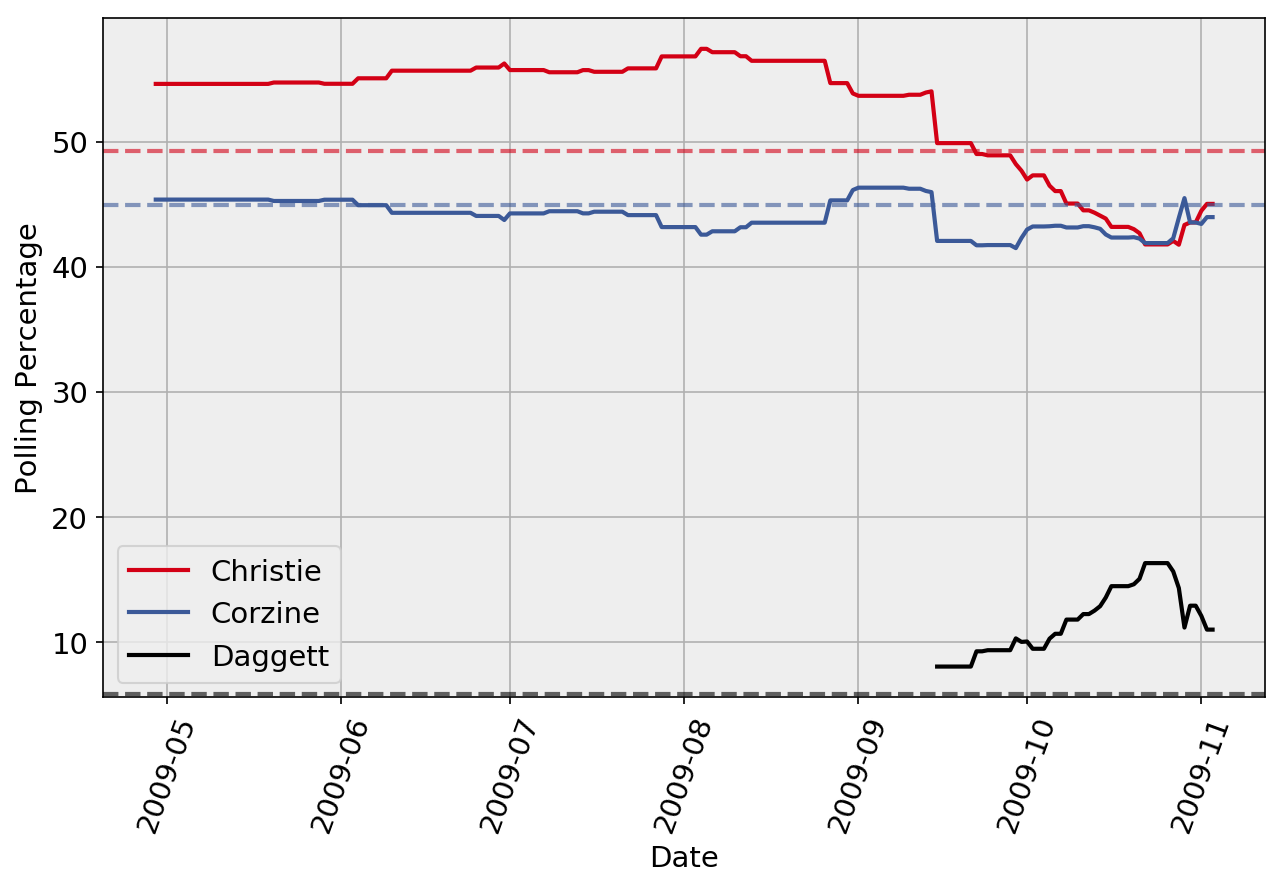

http://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html


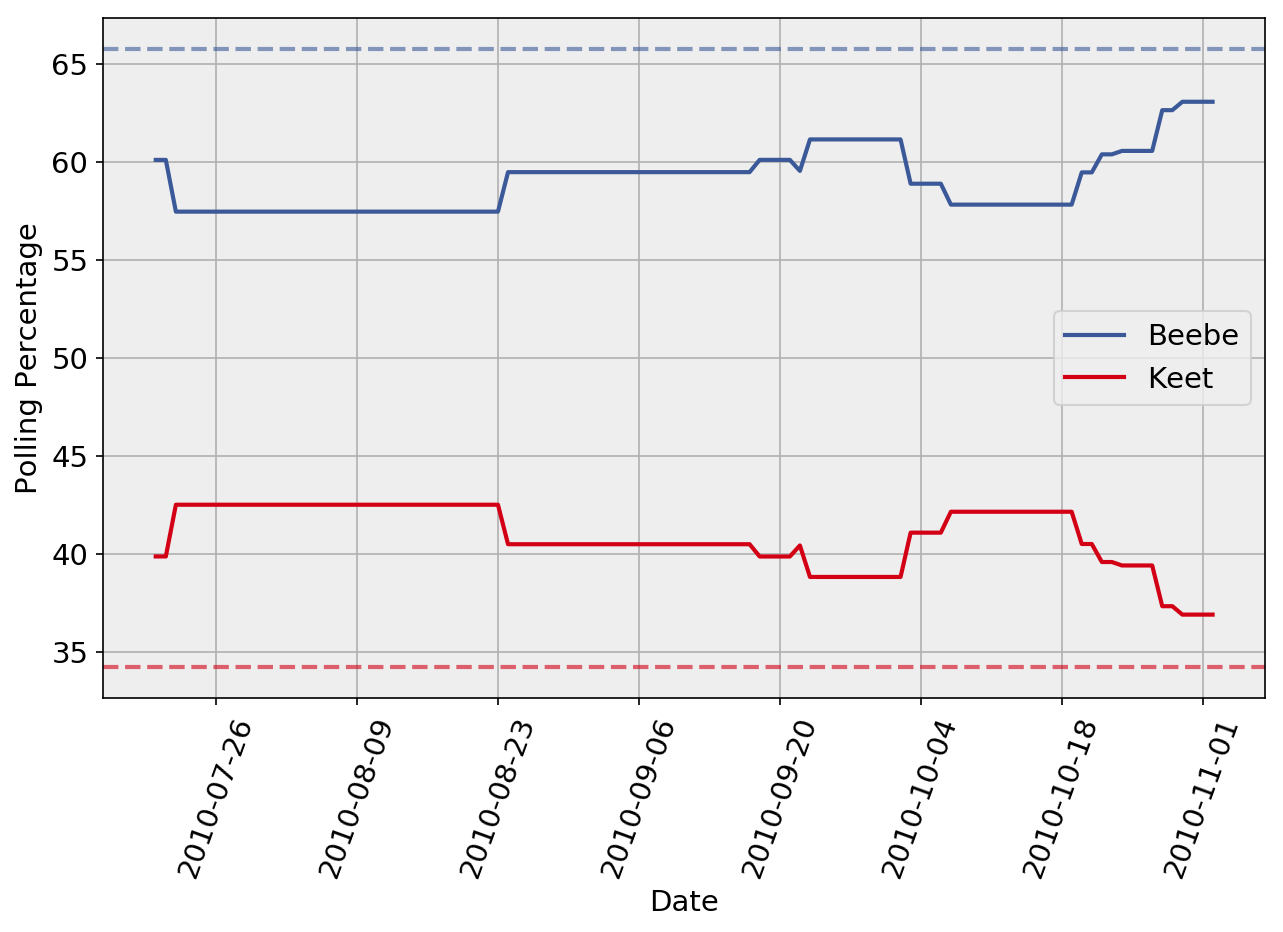

http://www.realclearpolitics.com/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html


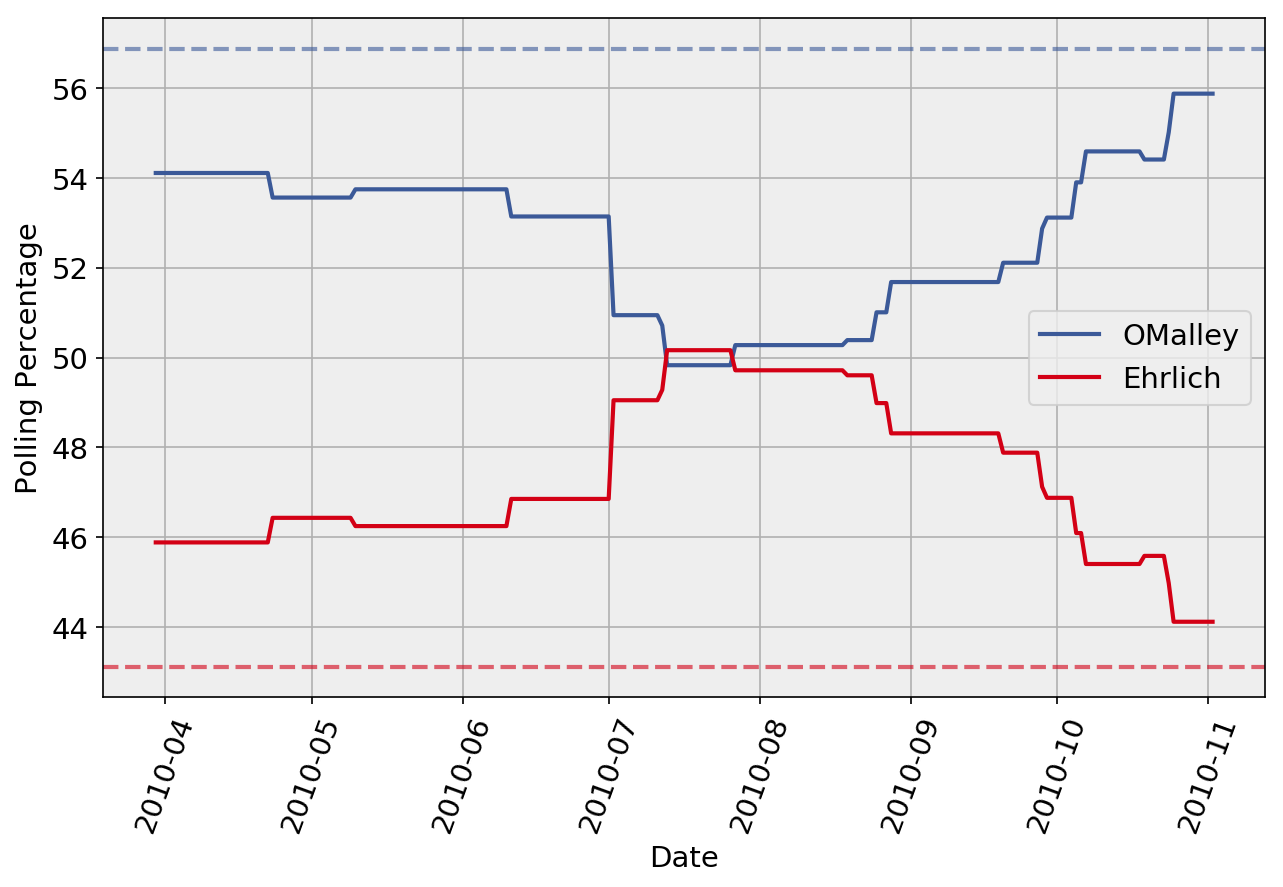

http://www.realclearpolitics.com/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html


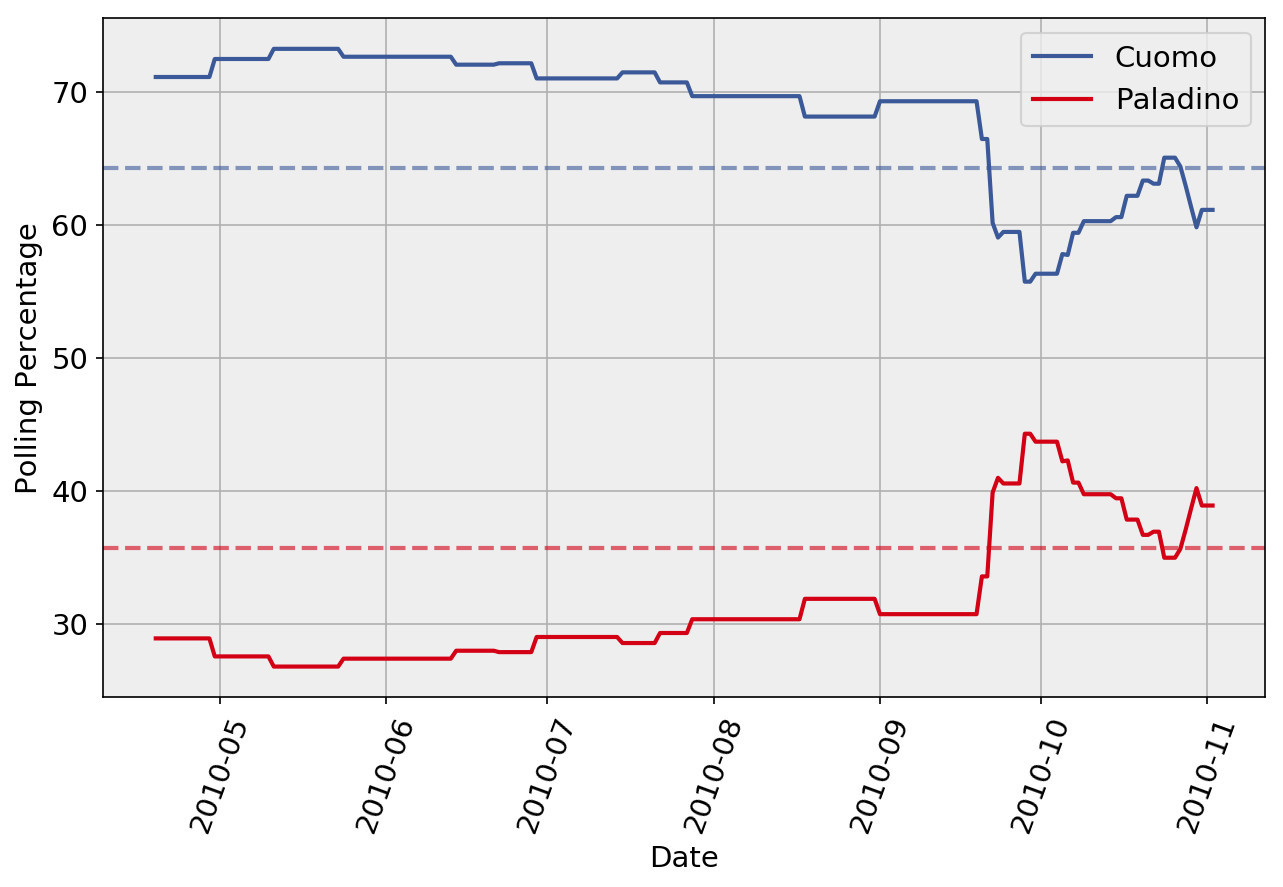

http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html


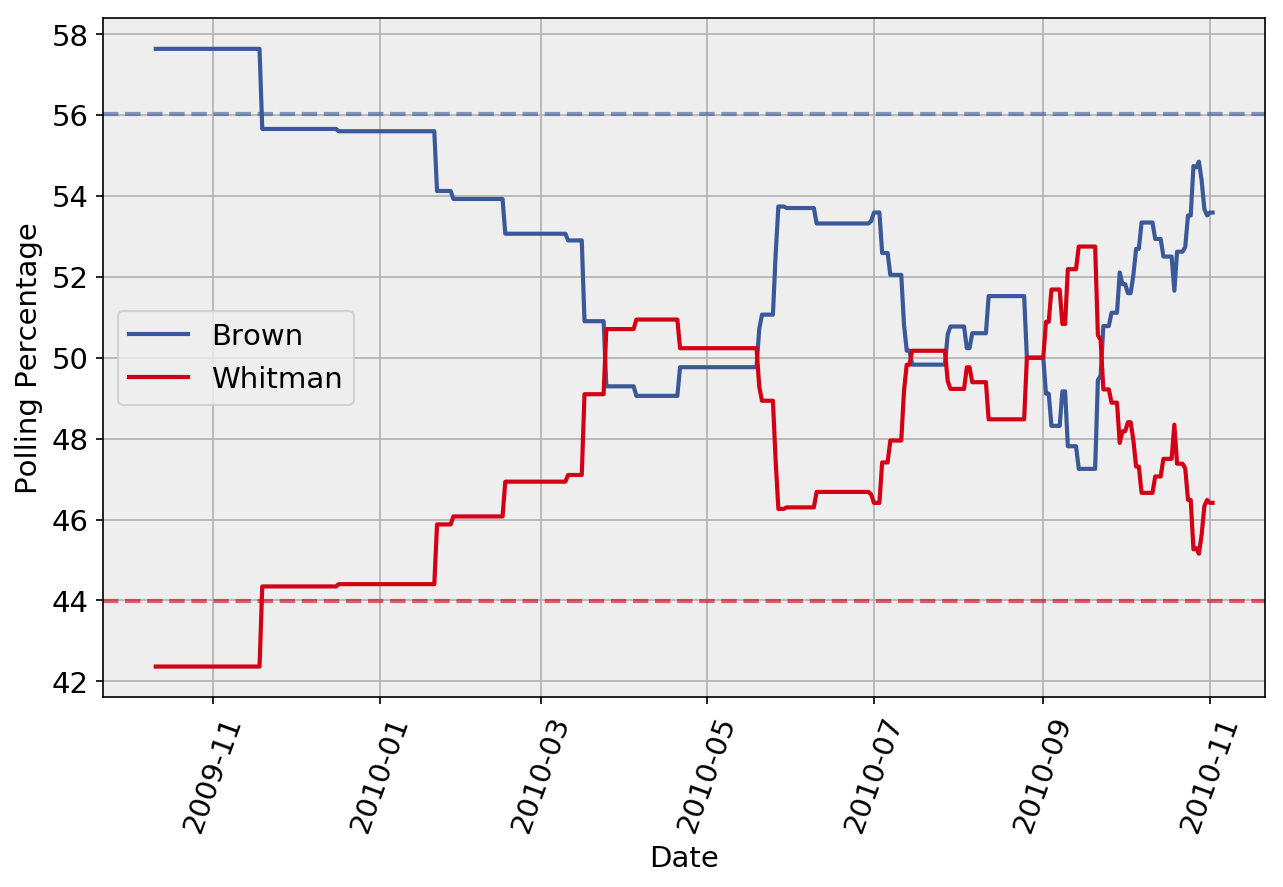

http://www.realclearpolitics.com/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html


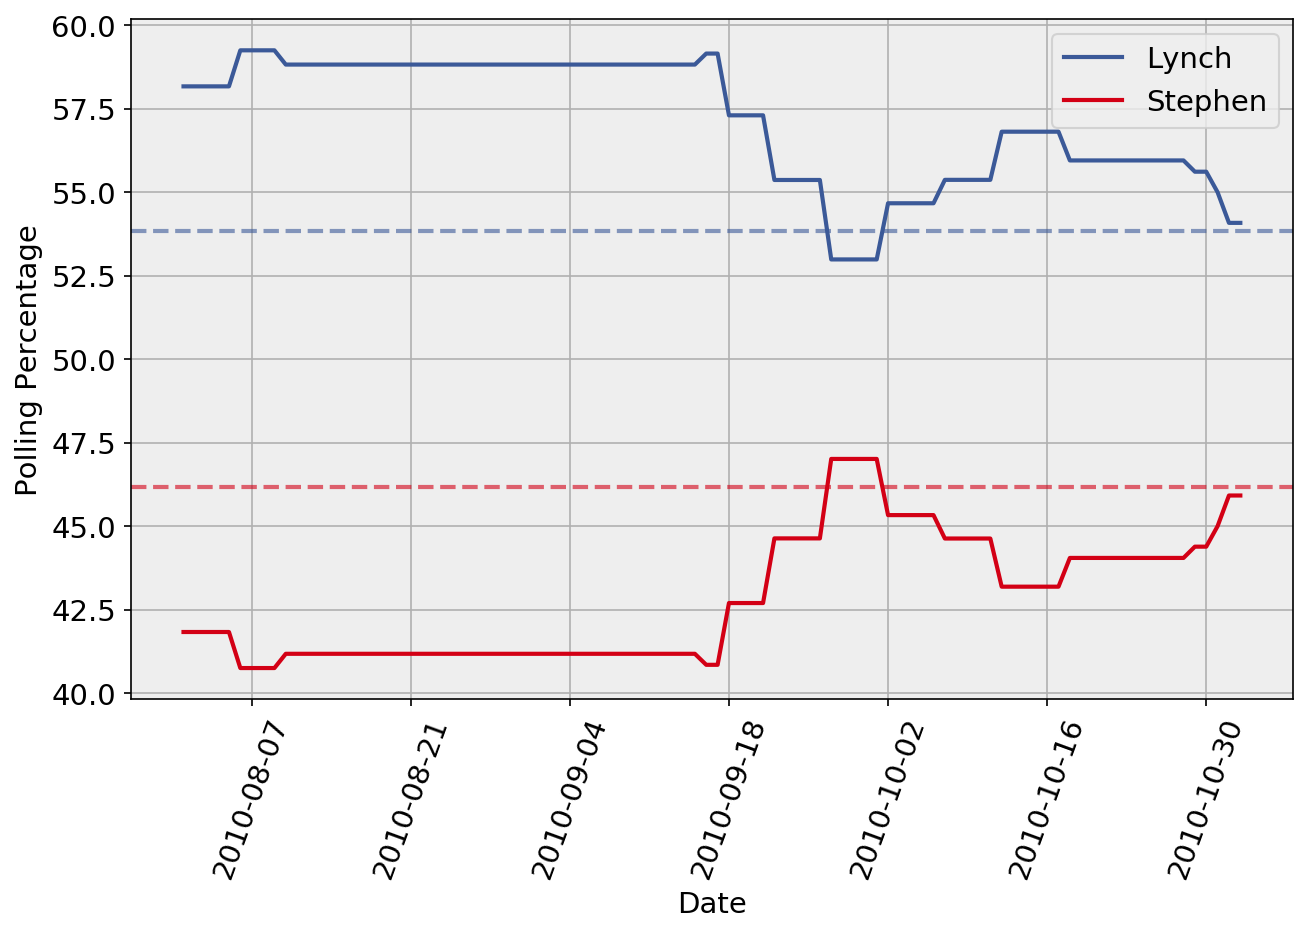

http://www.realclearpolitics.com/epolls/2010/governor/co/colorado_governor_maes_vs_hickenlooper_vs_tancredo-1677.html


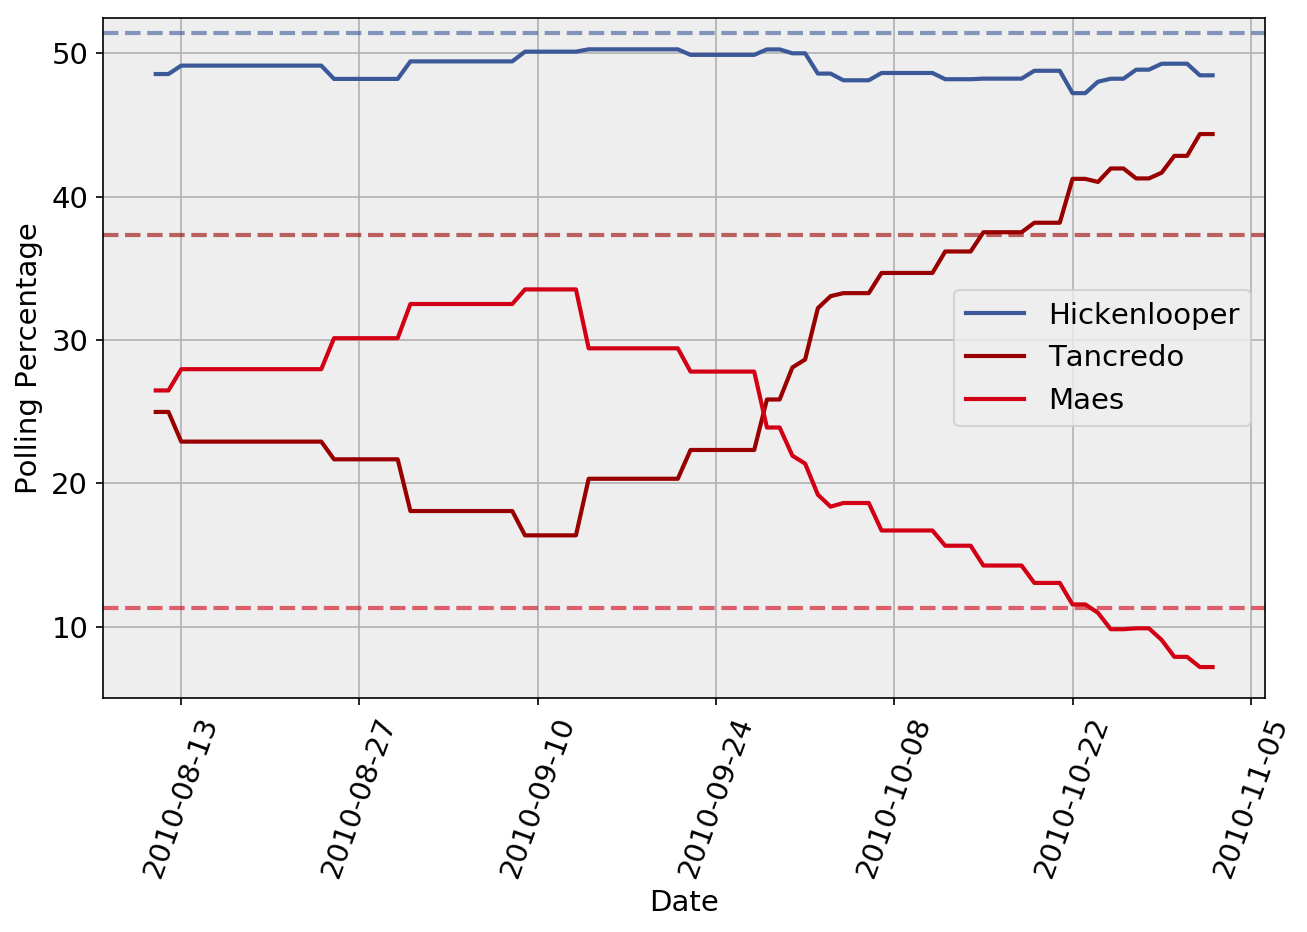

http://www.realclearpolitics.com/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html


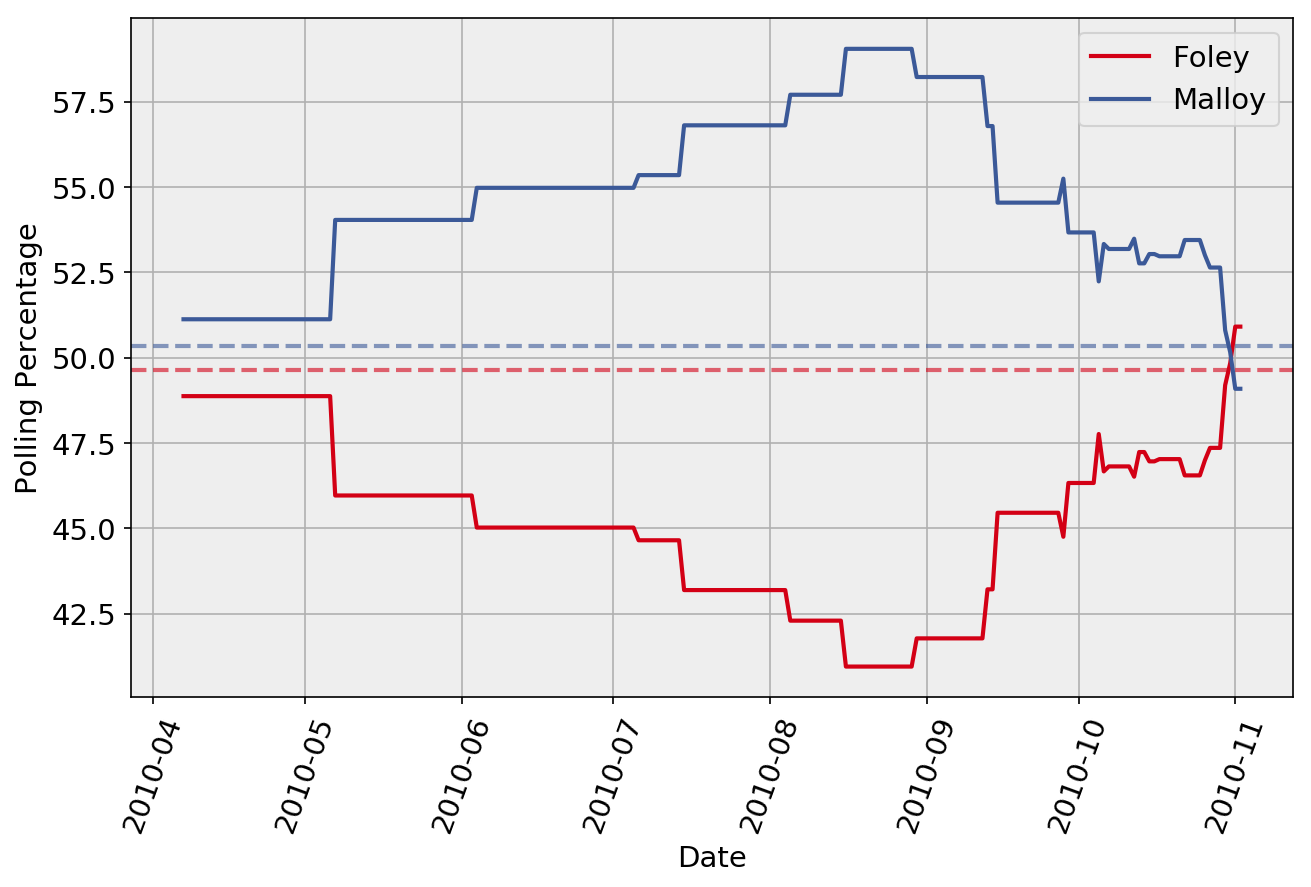

http://www.realclearpolitics.com/epolls/2010/governor/fl/florida_governor_scott_vs_sink_vs_chiles-1607.html


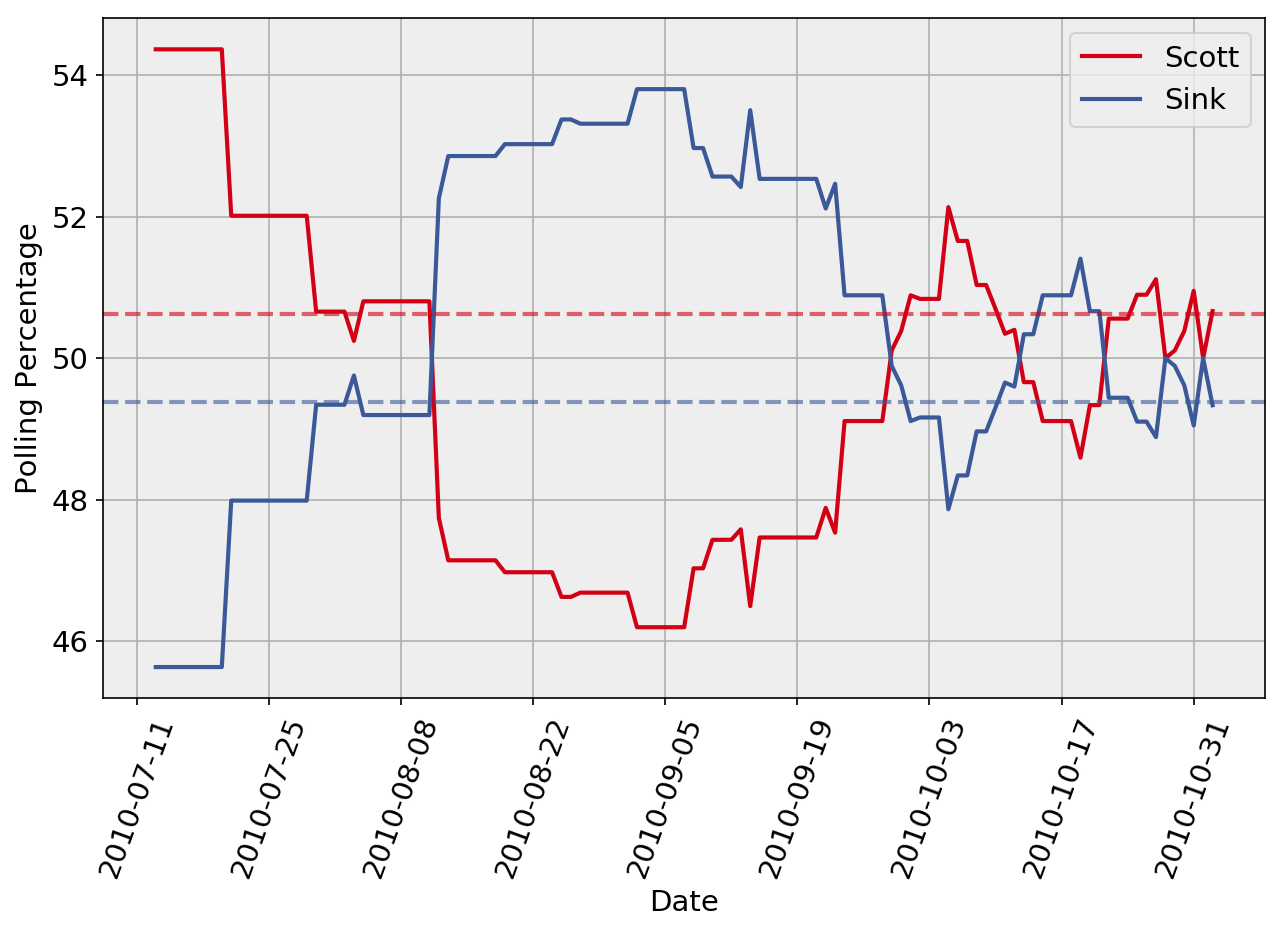

http://www.realclearpolitics.com/epolls/2010/governor/hi/hawaii_governor_aiona_vs_abercrombie-1163.html
http://www.realclearpolitics.com/epolls/2010/governor/il/illinois_governor_brady_vs_quinn-1361.html


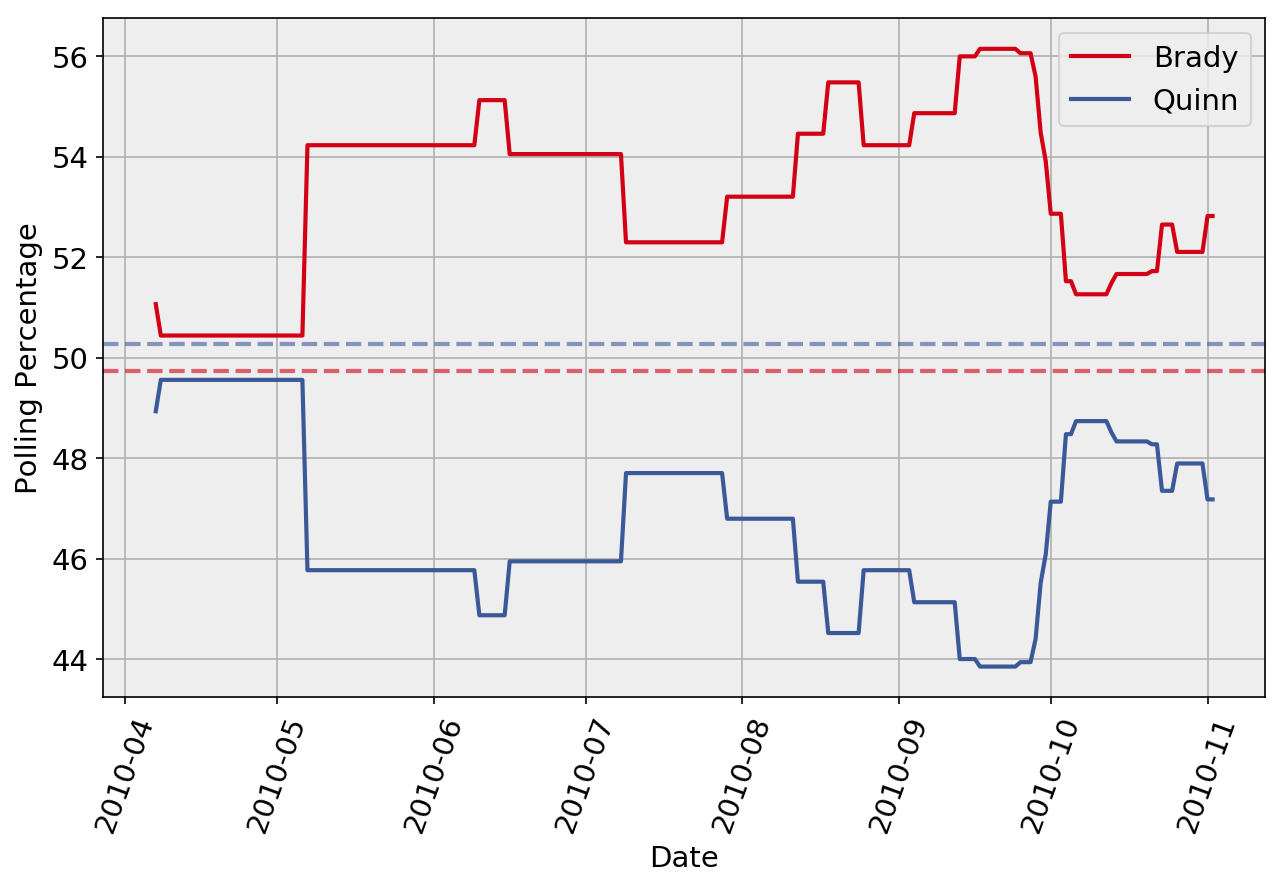

http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html


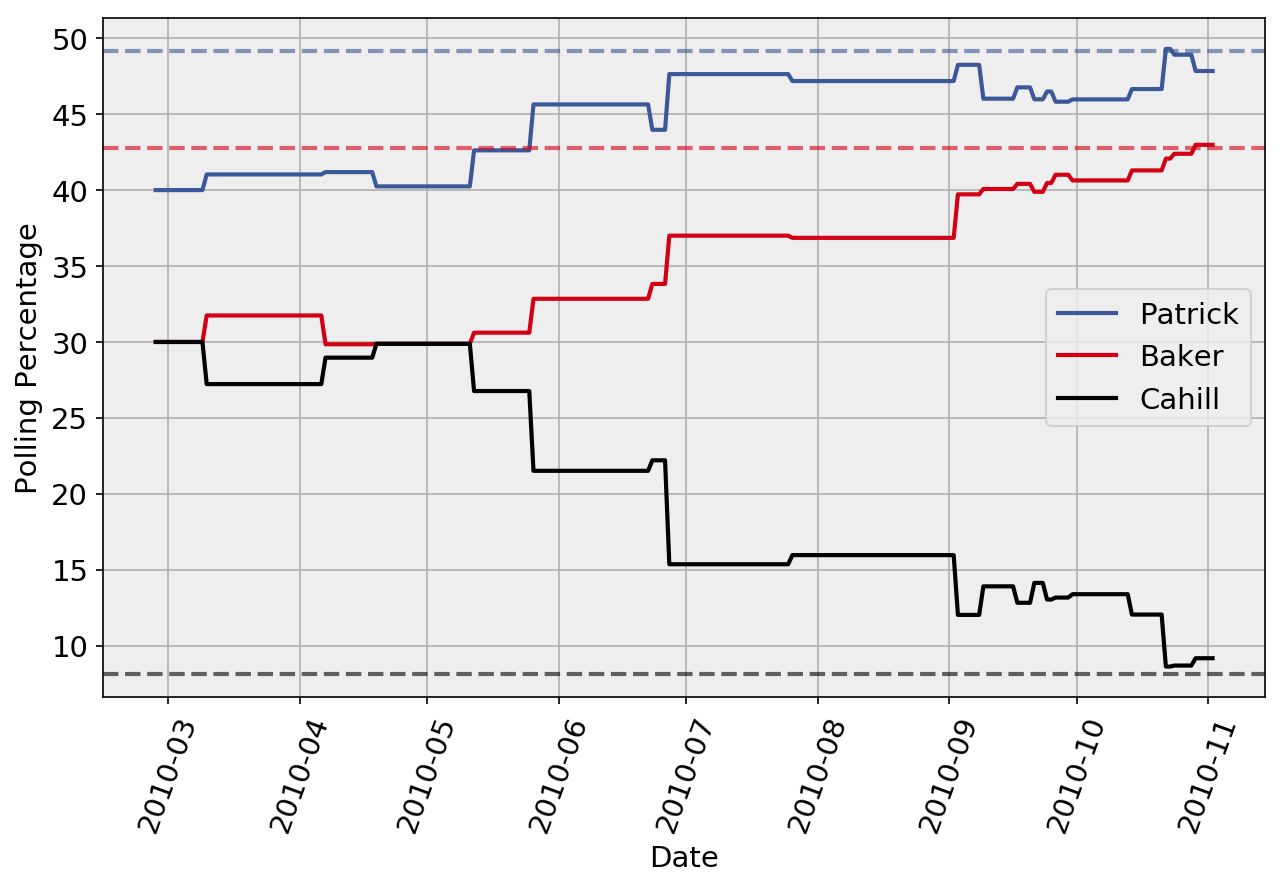

http://www.realclearpolitics.com/epolls/2010/governor/mn/minnesota_governor_emmer_vs_dayton_vs_horner-1393.html


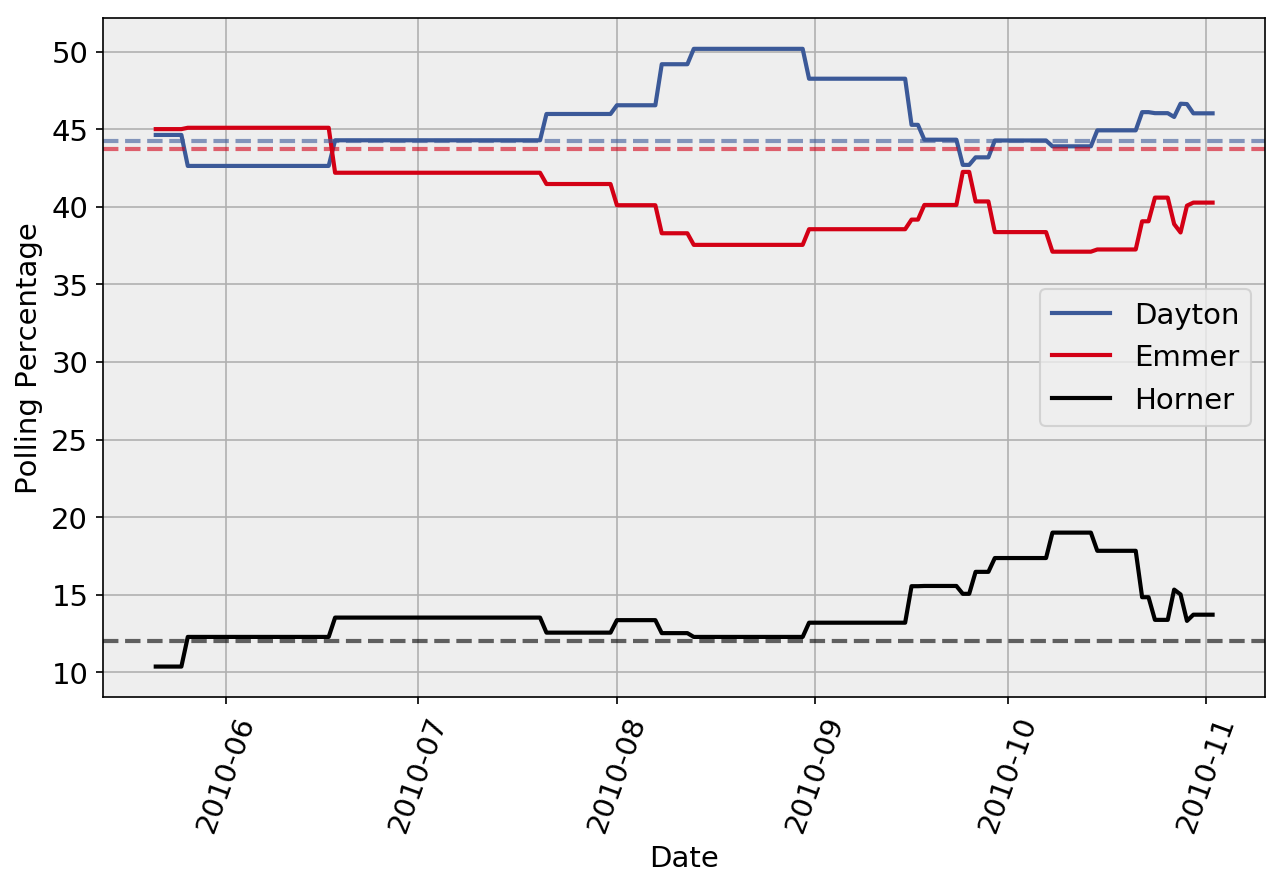

http://www.realclearpolitics.com/epolls/2010/governor/oh/ohio_governor_kasich_vs_strickland-1078.html


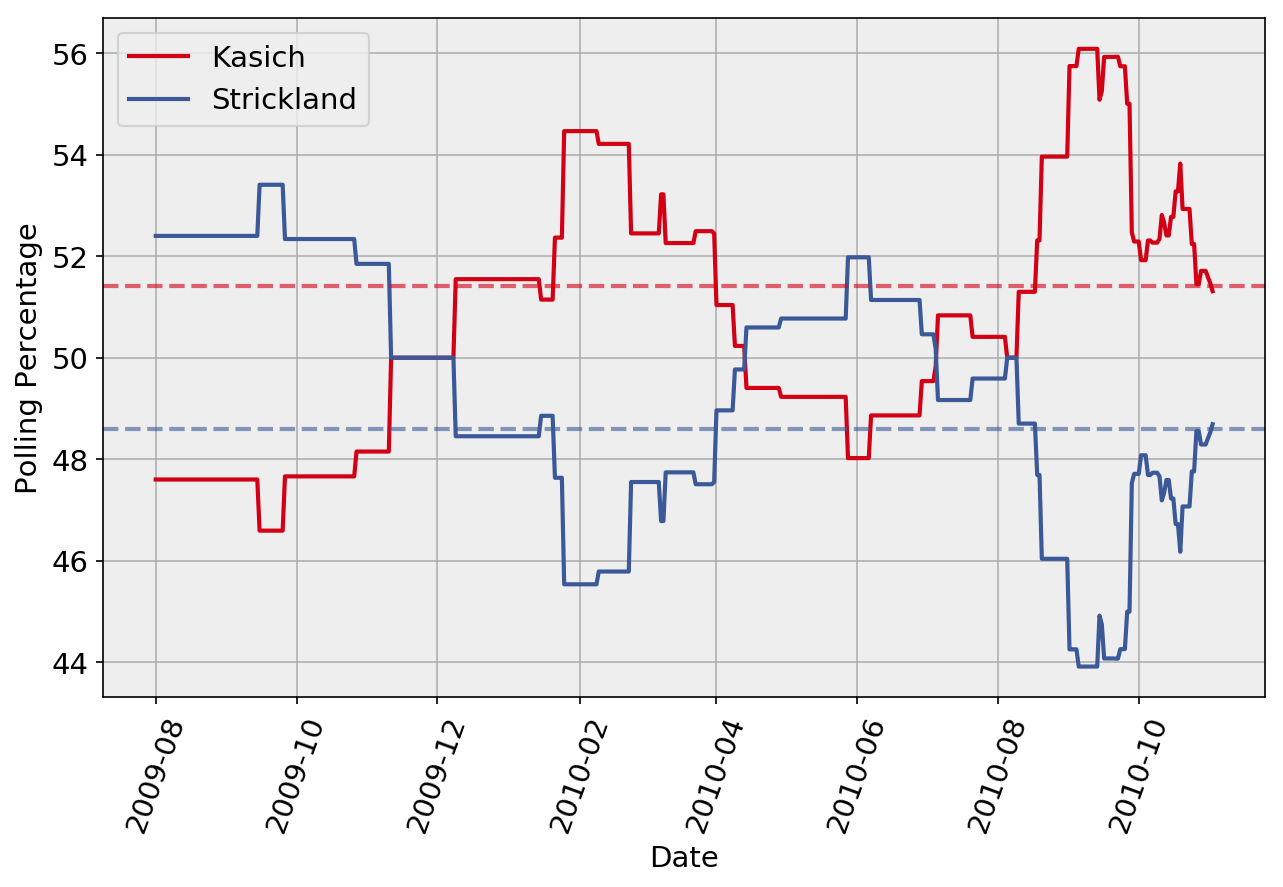

http://www.realclearpolitics.com/epolls/2010/governor/or/oregon_governor_dudley_vs_kitzhaber-1088.html


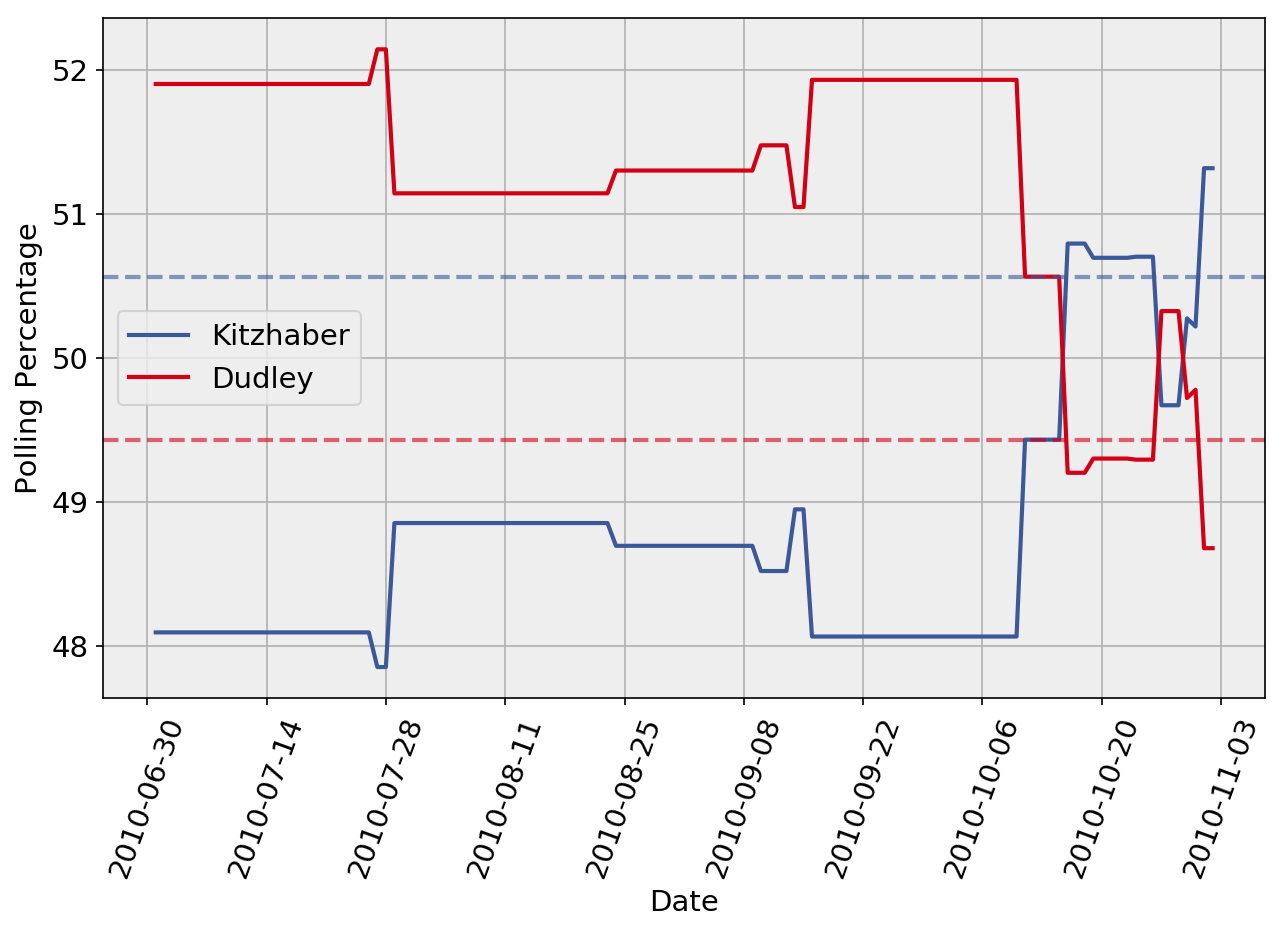

http://www.realclearpolitics.com/epolls/2010/governor/ri/rhode_island_governor_chafee_vs_caprio_vs_robitaille-1232.html


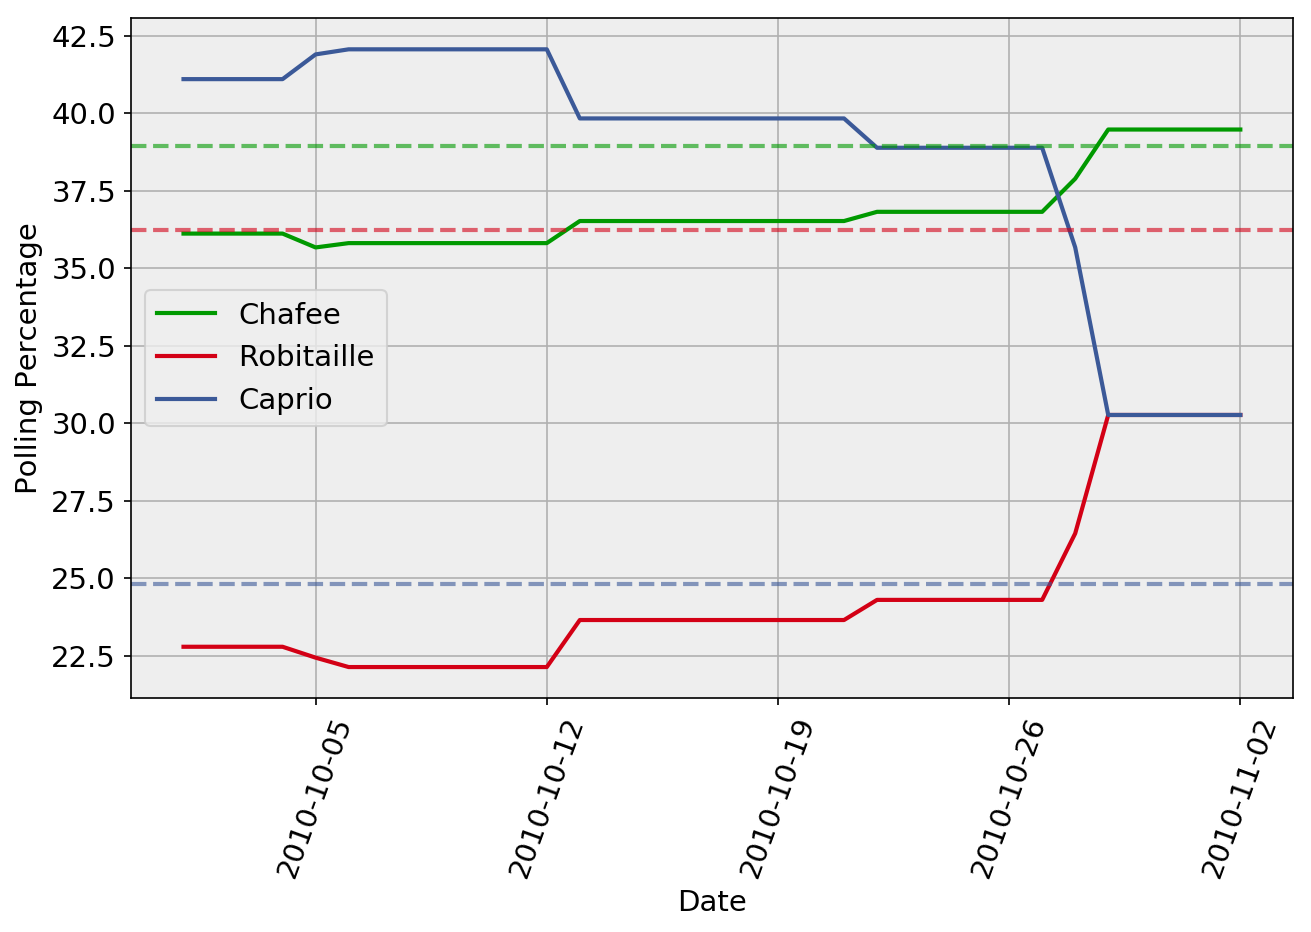

http://www.realclearpolitics.com/epolls/2010/governor/vt/vermont_governor_dubie_vs_shumlin-1228.html
http://www.realclearpolitics.com/epolls/2010/governor/az/arizona_governor_brewer_vs_goddard-1409.html


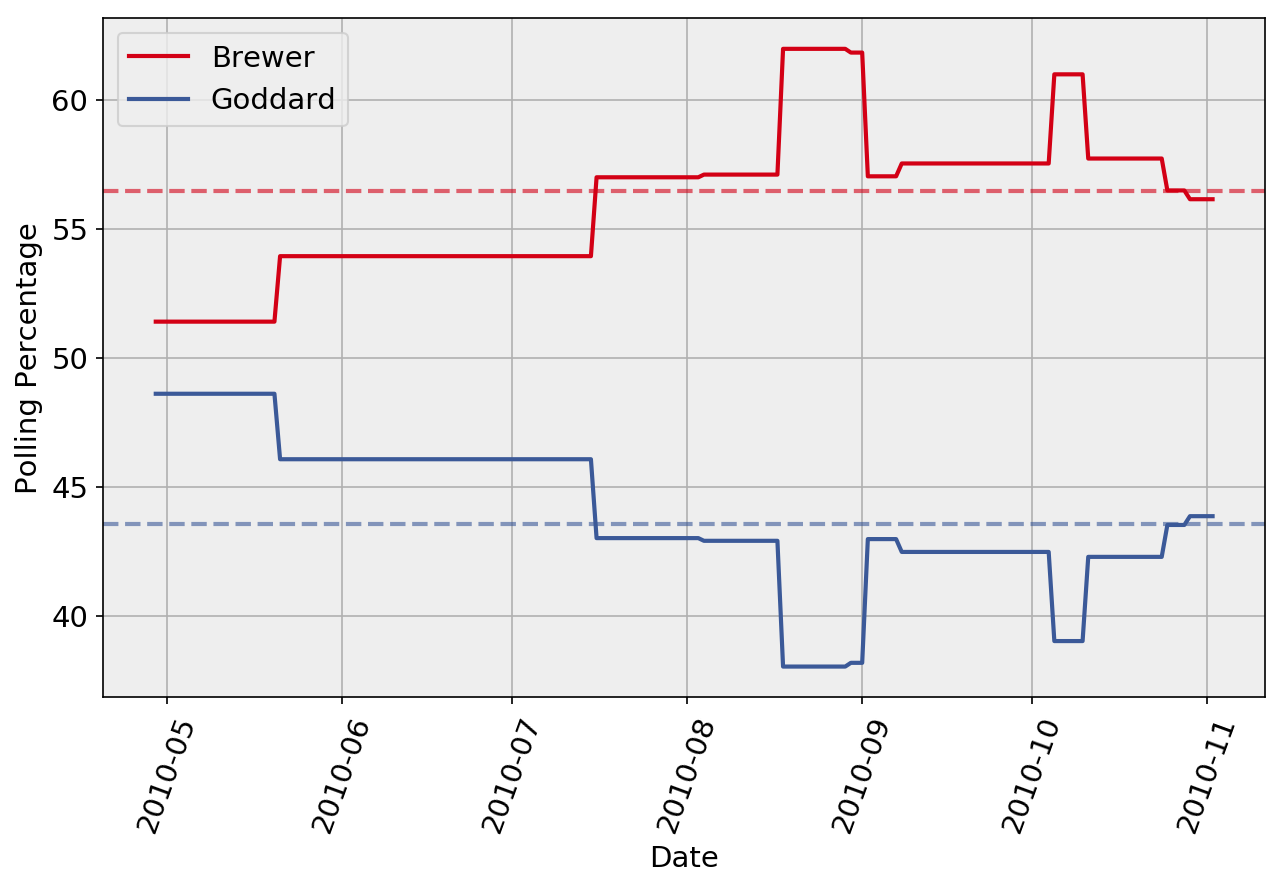

http://www.realclearpolitics.com/epolls/2010/governor/ga/georgia_governor_deal_vs_barnes-1316.html


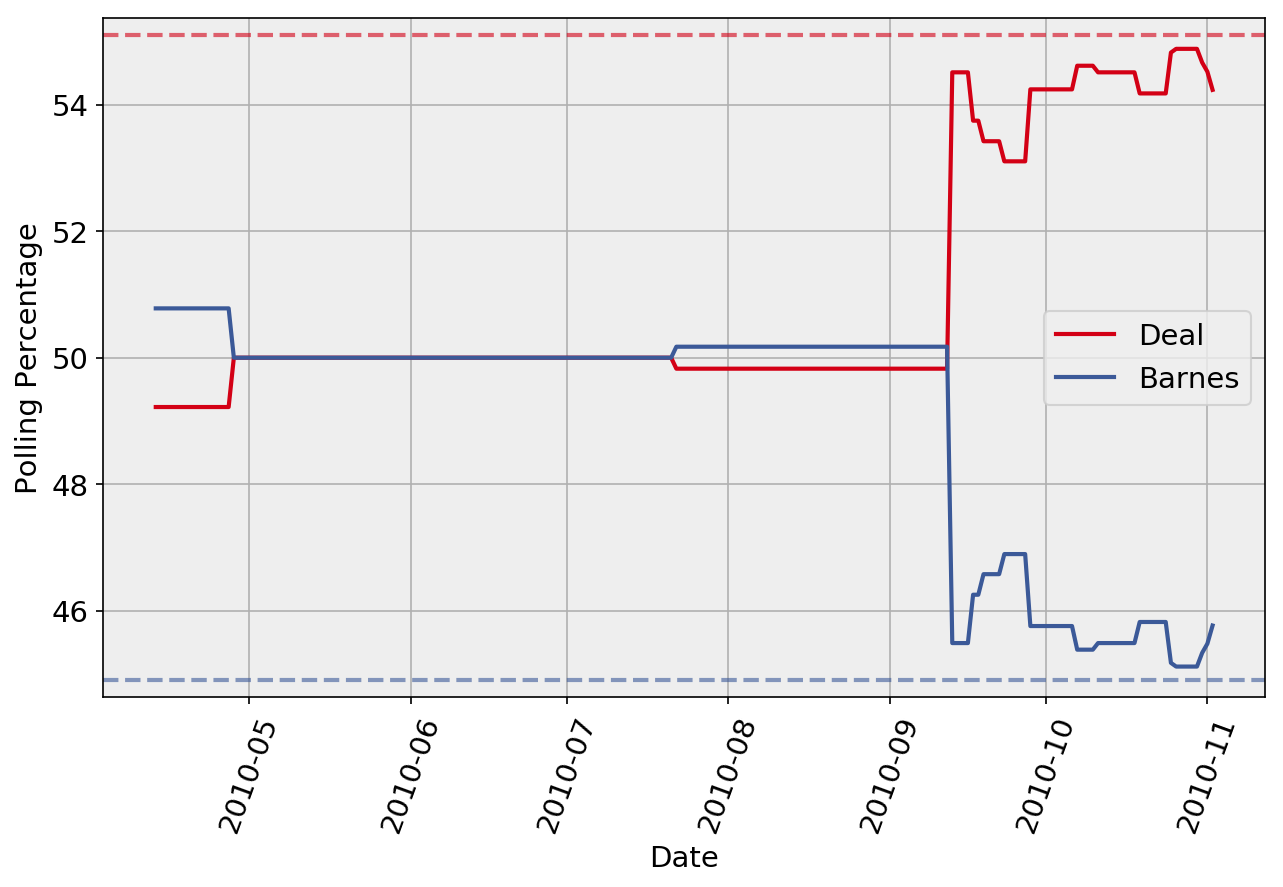

http://www.realclearpolitics.com/epolls/2010/governor/nm/new_mexico_governor_martinez_vs_denish-1323.html


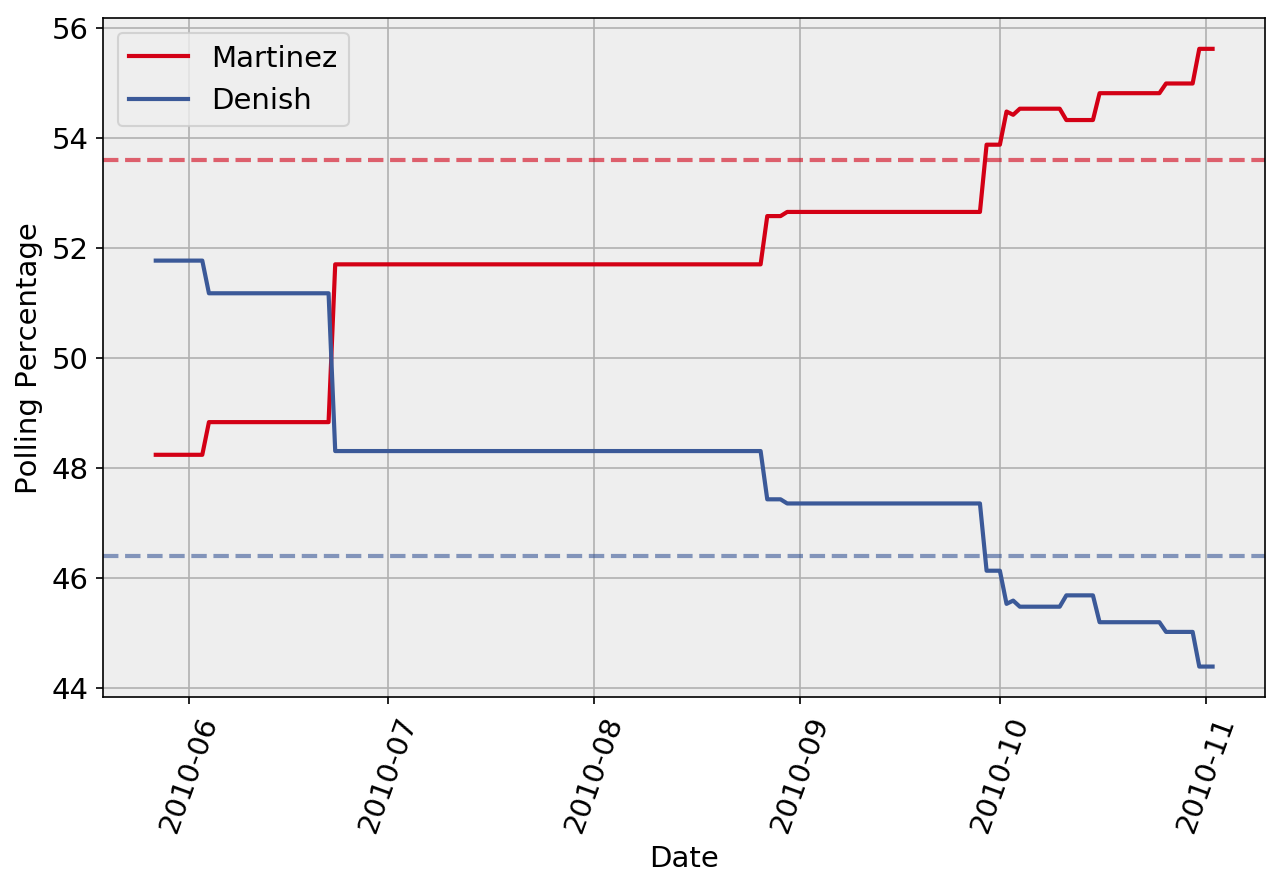

http://www.realclearpolitics.com/epolls/2010/governor/pa/pennsylvania_governor_corbett_vs_onorato-1333.html


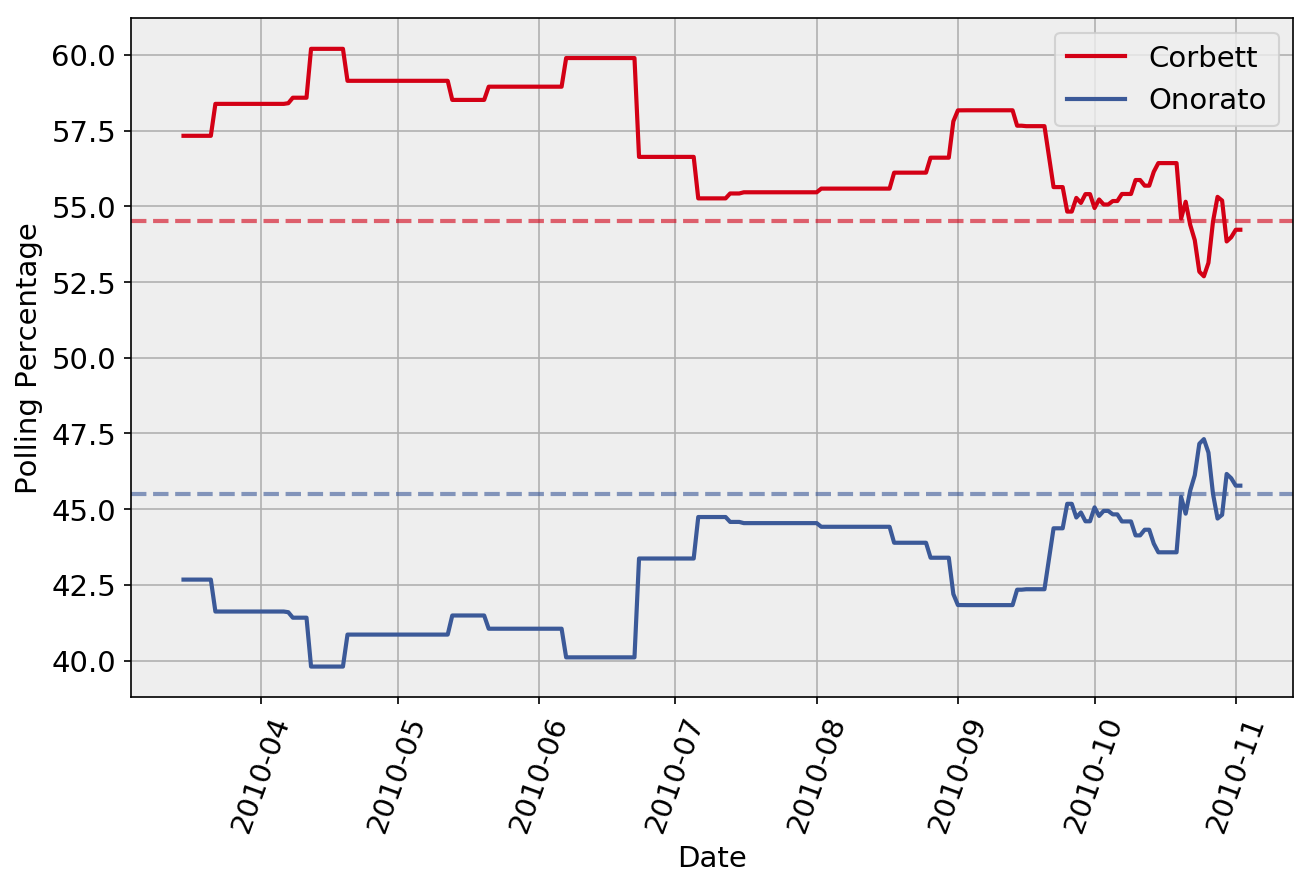

http://www.realclearpolitics.com/epolls/2010/governor/sc/south_carolina_governor_haley_vs_sheheen-1574.html


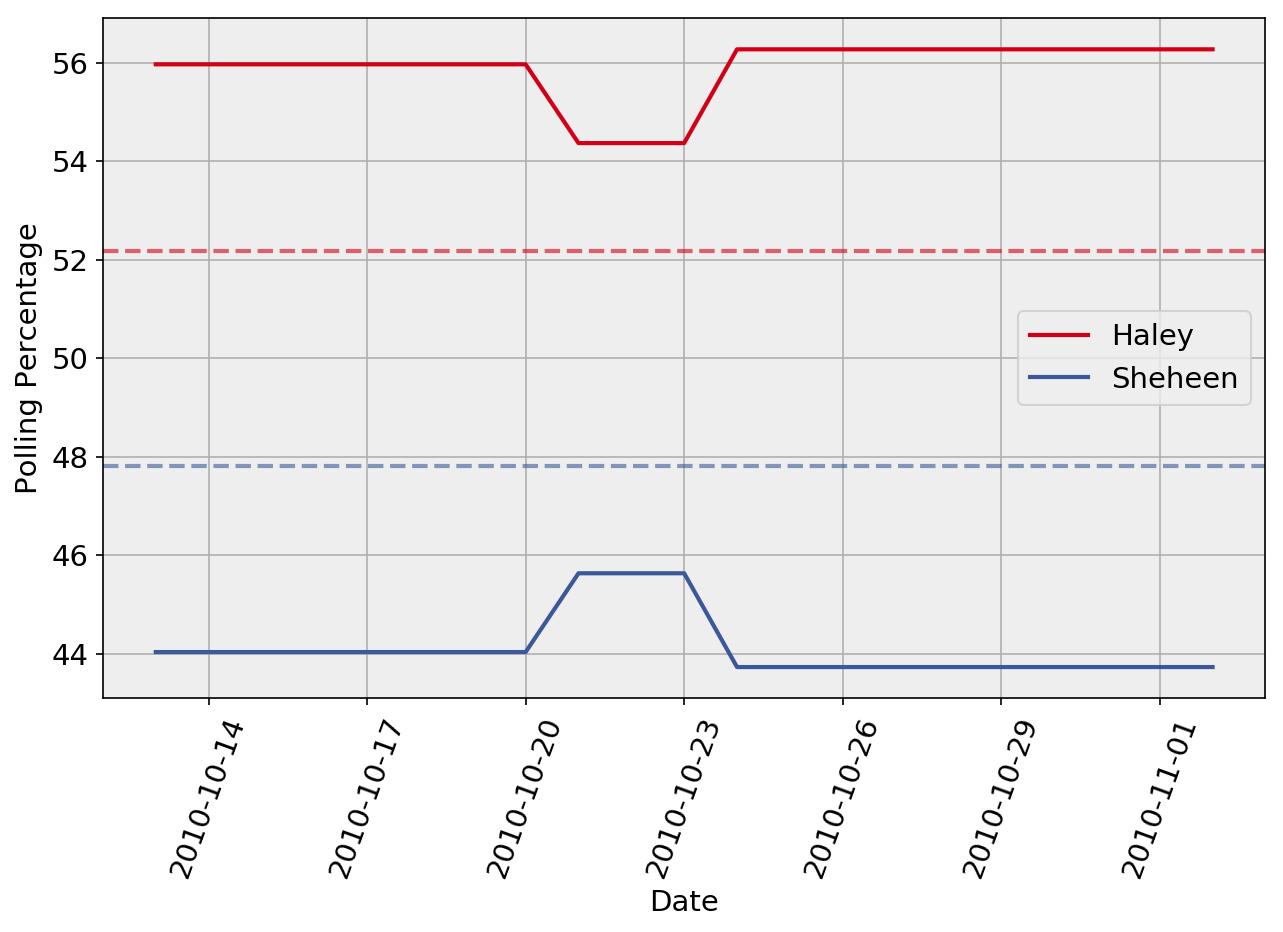

http://www.realclearpolitics.com/epolls/2010/governor/tx/texas_governor_perry_vs_white-1194.html


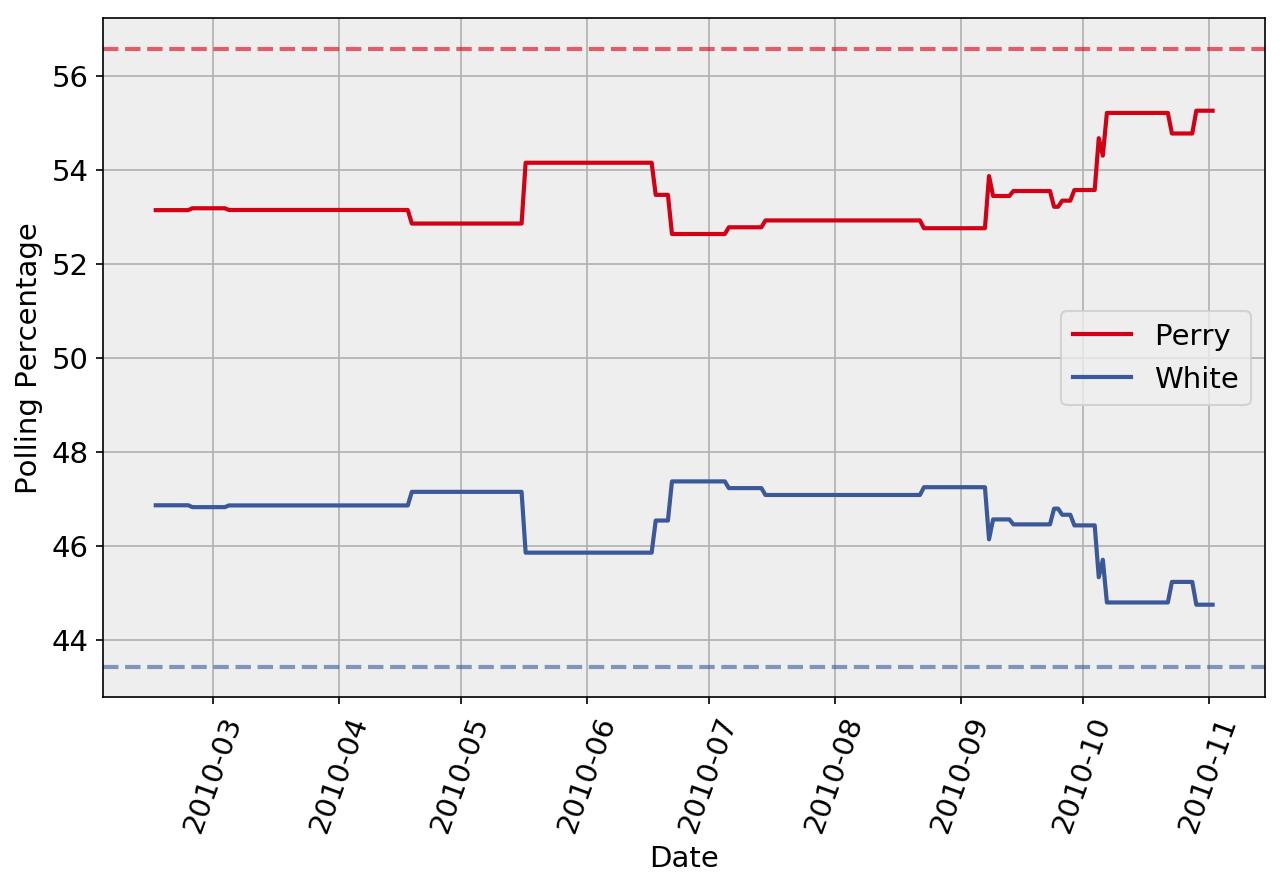

http://www.realclearpolitics.com/epolls/2010/governor/wi/wisconsin_governor_walker_vs_barrett-1184.html


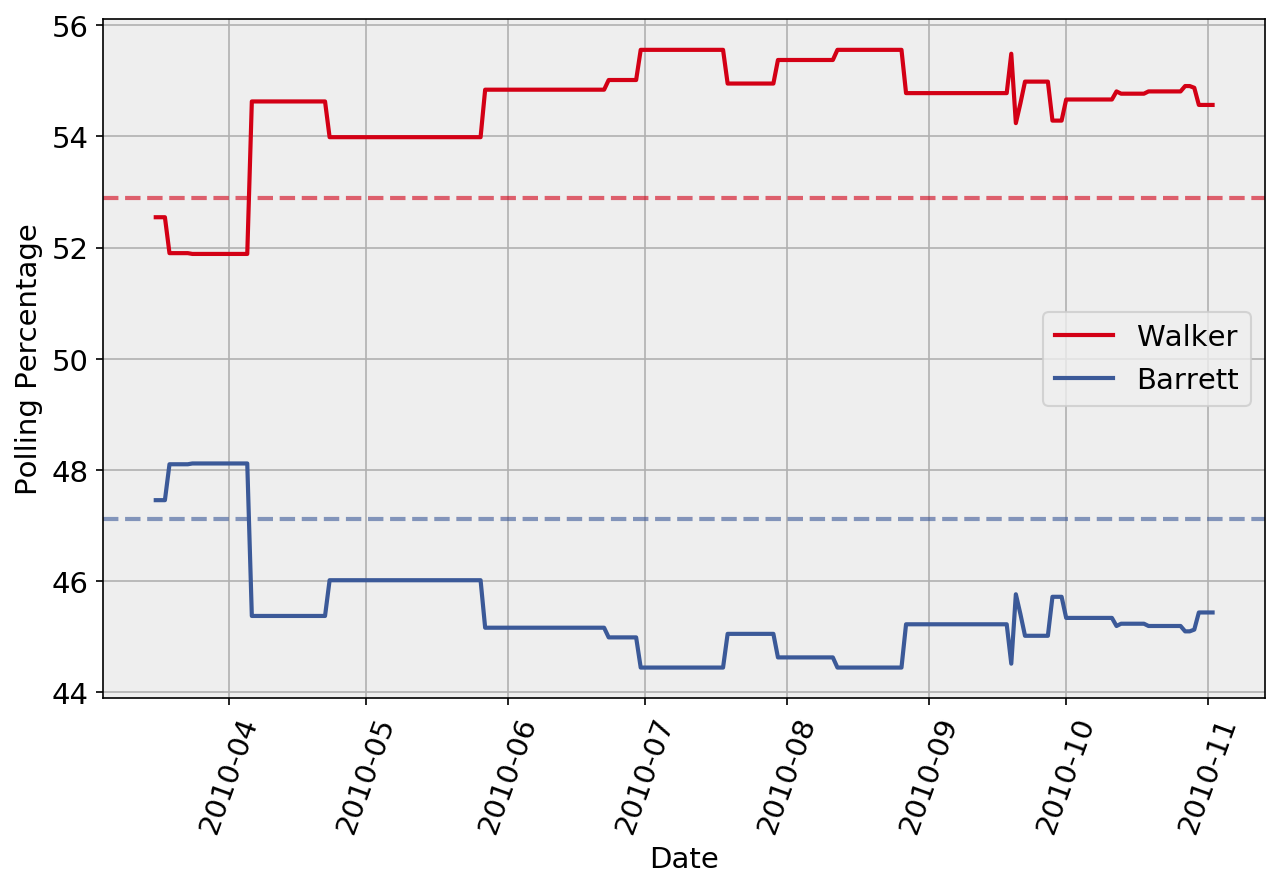

http://www.realclearpolitics.com/epolls/2010/governor/ak/alaska_governor_parnell_vs_berkowitz-1510.html


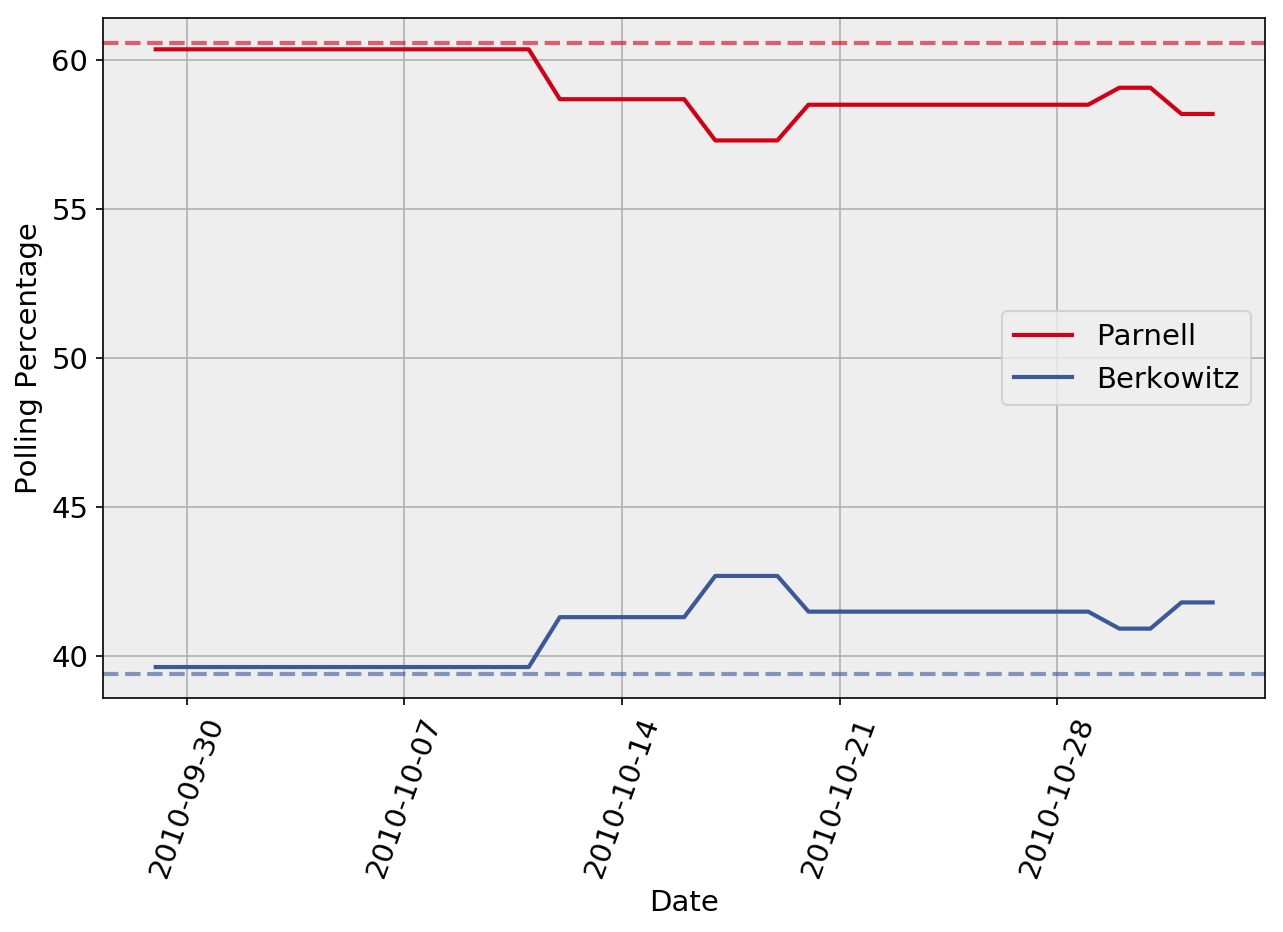

http://www.realclearpolitics.com/epolls/2010/governor/ia/iowa_governor_branstad_vs_culver-1200.html


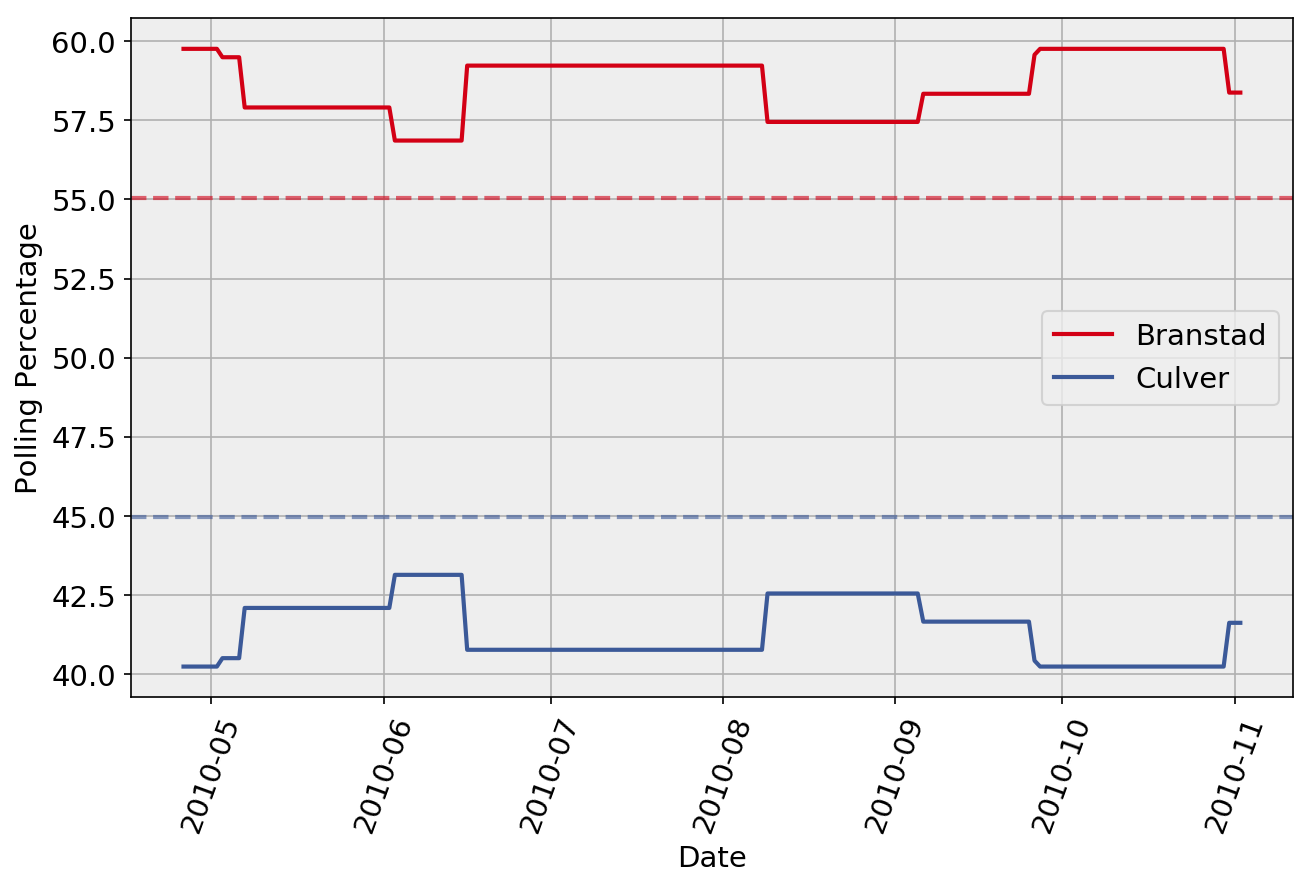

http://www.realclearpolitics.com/epolls/2010/governor/me/maine_governor_lepage_vs_mitchell_vs_cutler-1231.html


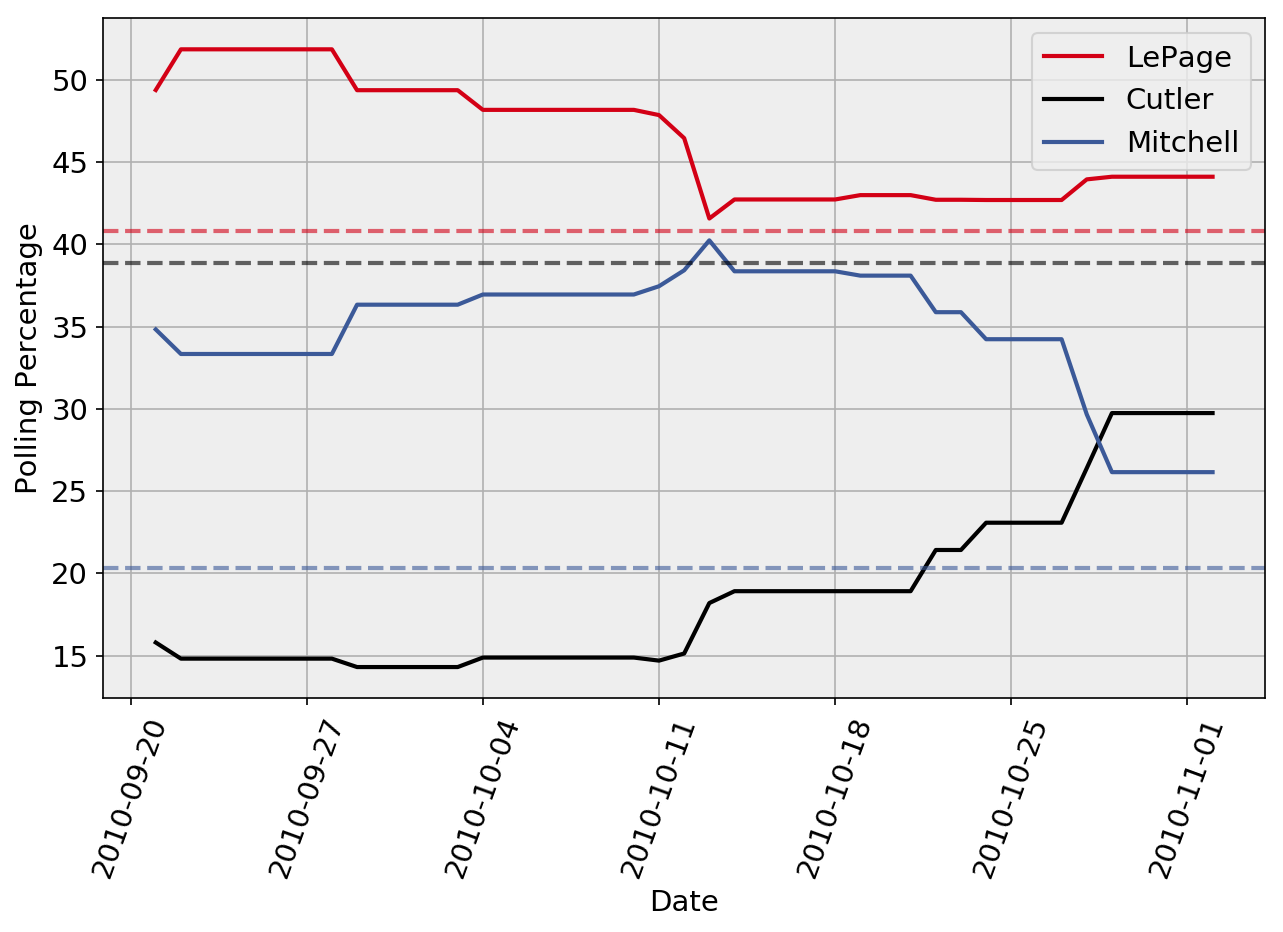

http://www.realclearpolitics.com/epolls/2010/governor/mi/michigan_governor_snyder_vs_bernero-1407.html


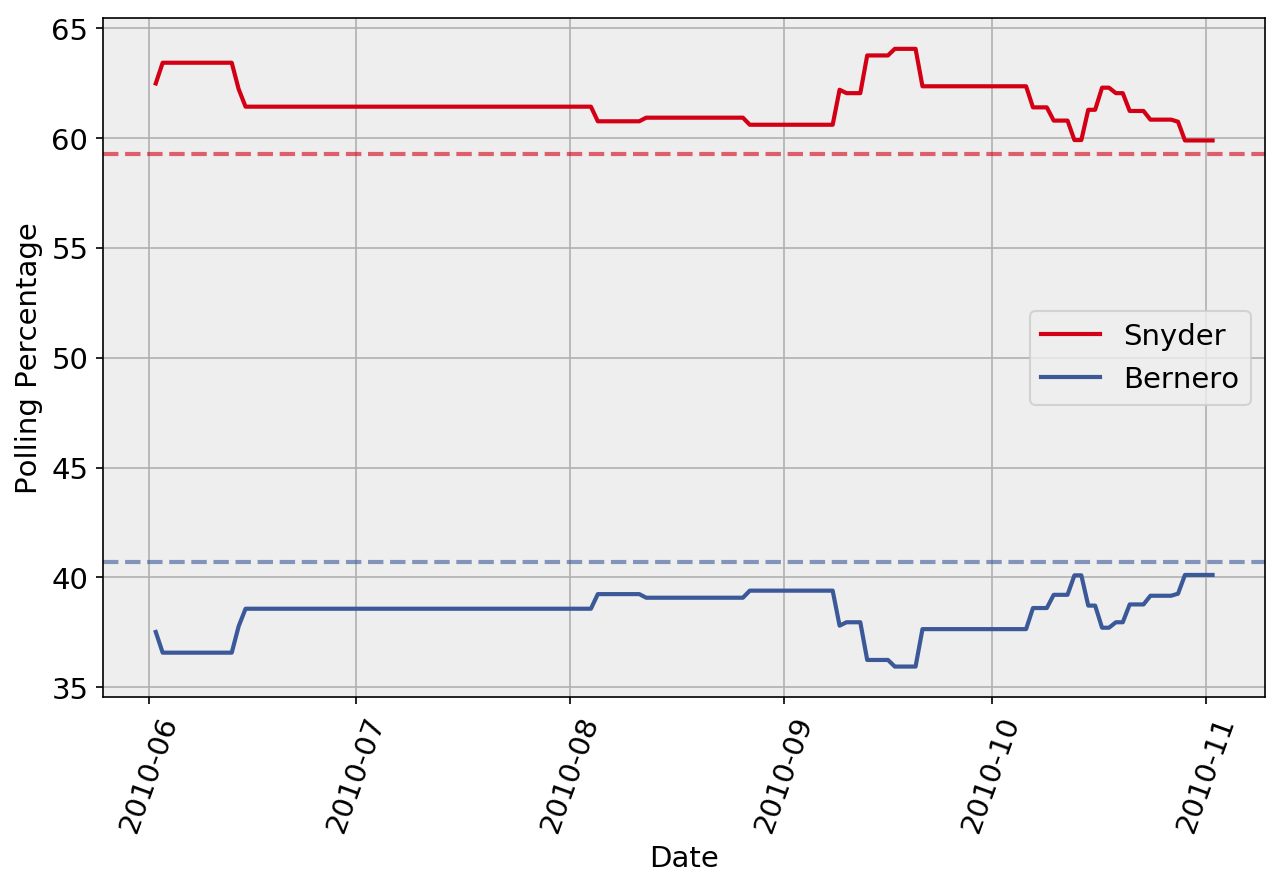

http://www.realclearpolitics.com/epolls/2010/governor/nv/nevada_governor_sandoval_vs_reid-1137.html


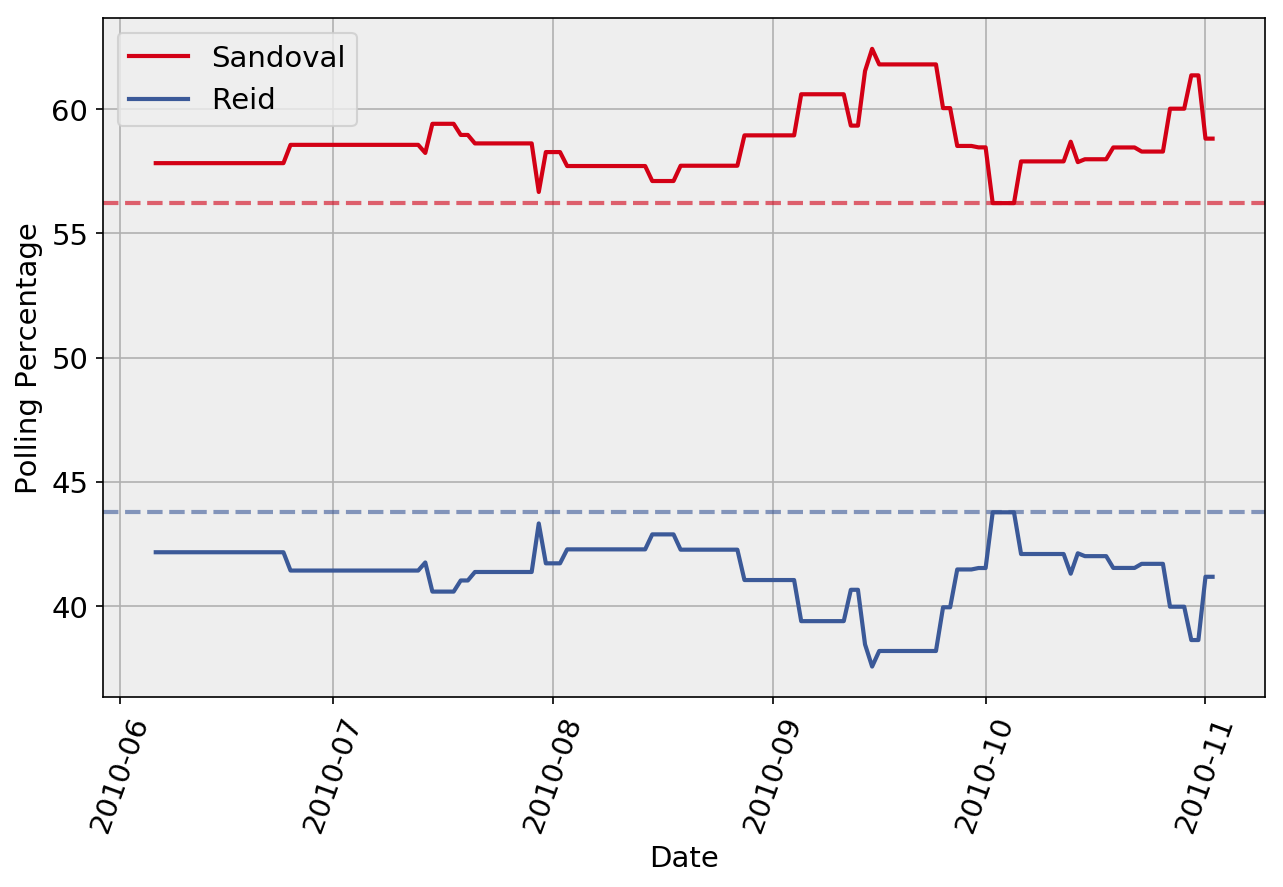

http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html


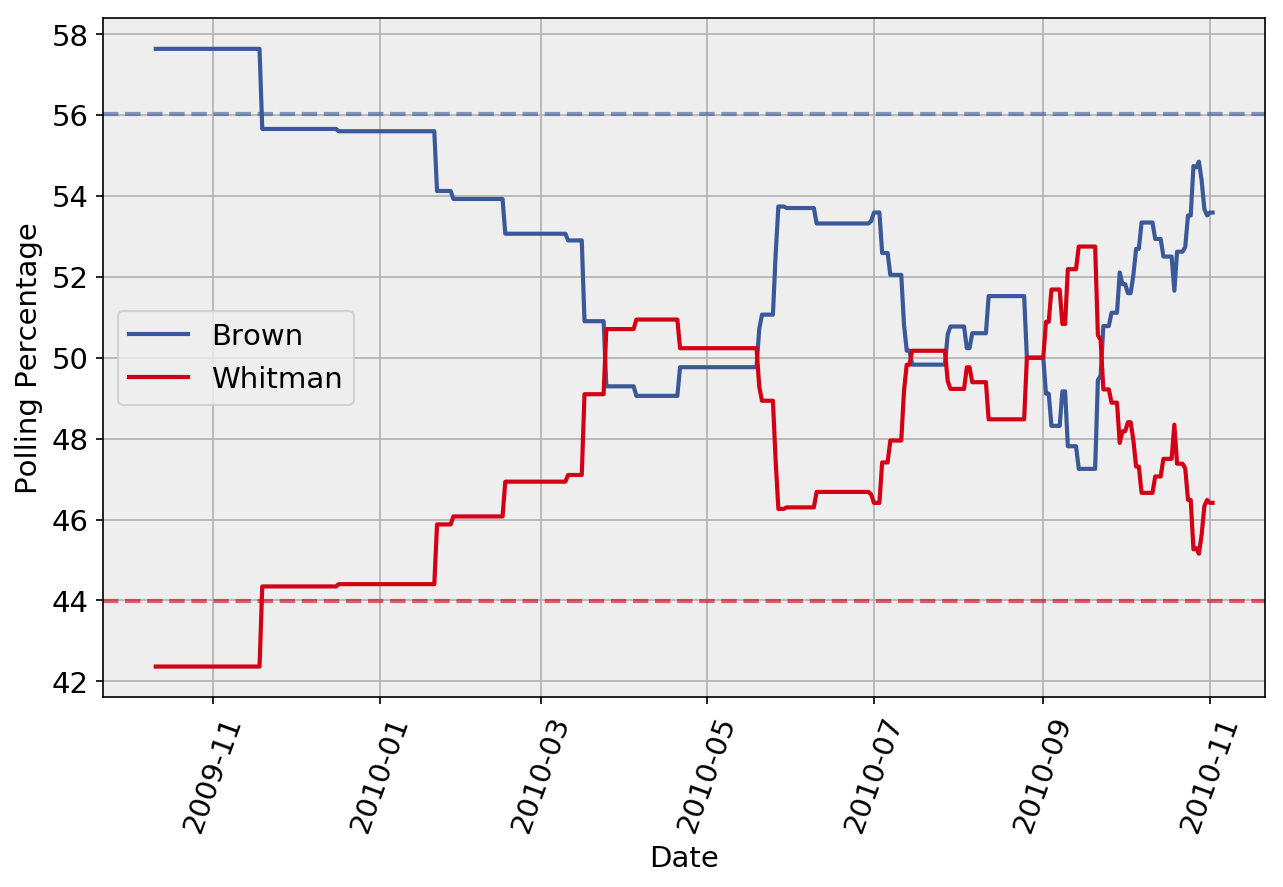

http://www.realclearpolitics.com/epolls/2010/governor/nm/new_mexico_governor_martinez_vs_denish-1323.html


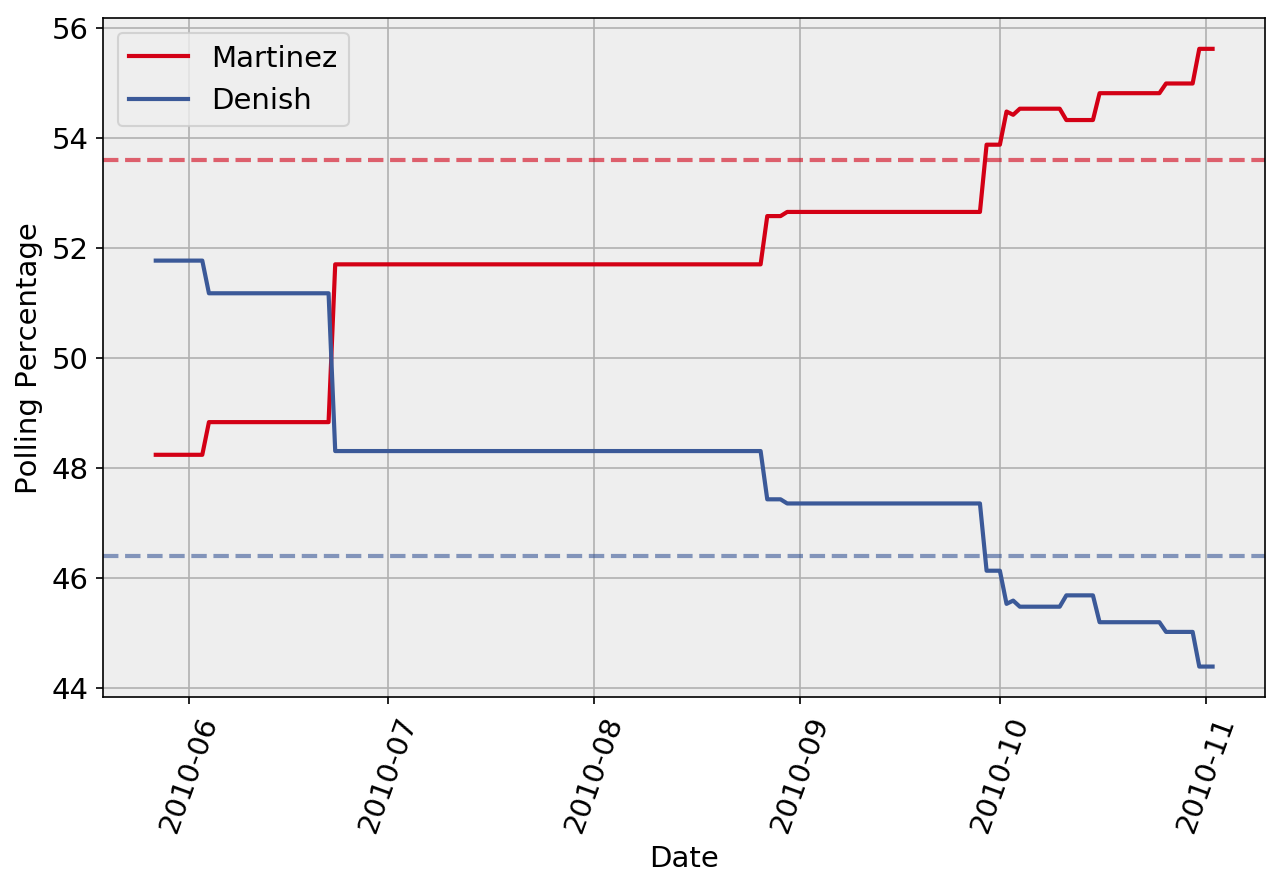

http://www.realclearpolitics.com/epolls/2010/governor/pa/pennsylvania_governor_corbett_vs_onorato-1333.html


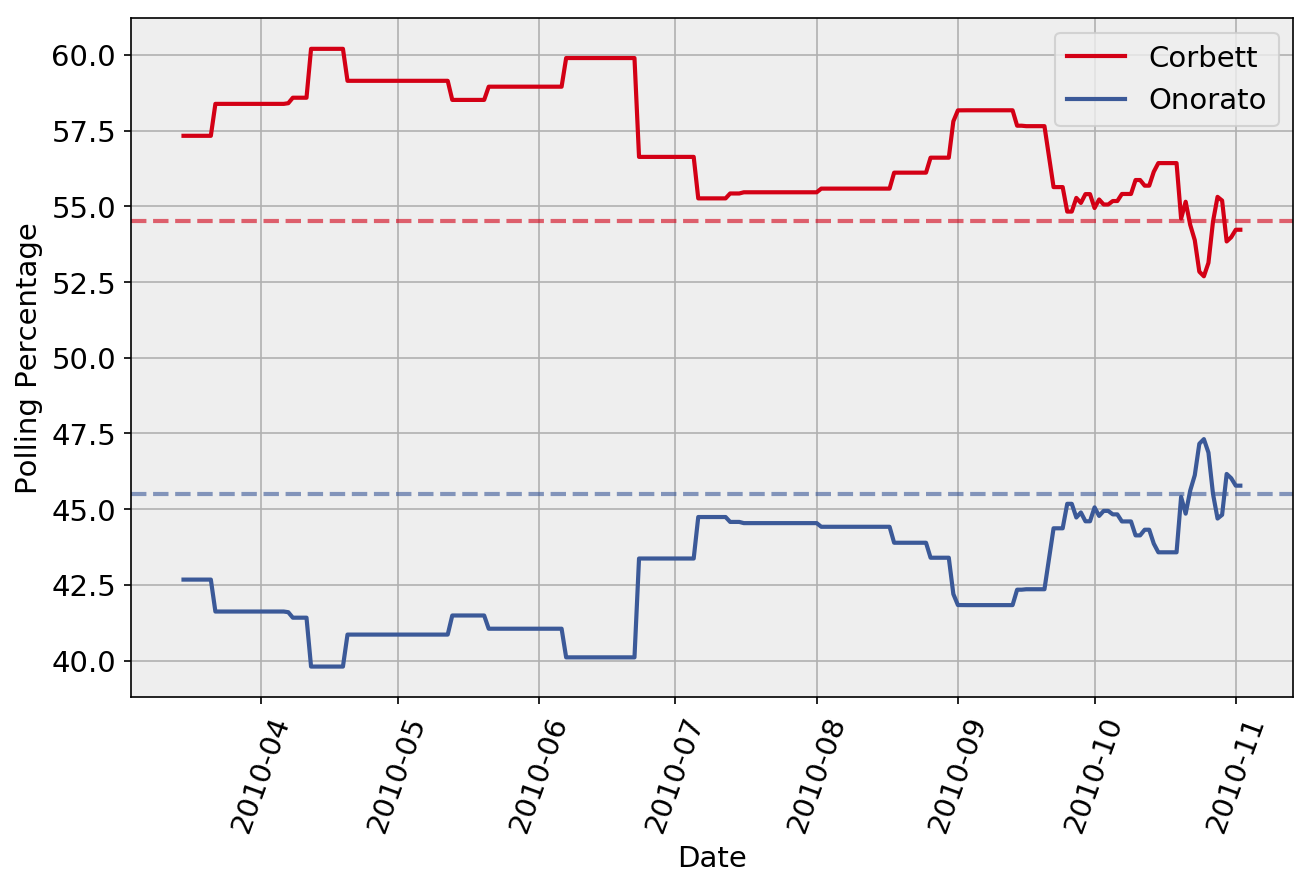

http://www.realclearpolitics.com/epolls/2010/governor/wi/wisconsin_governor_walker_vs_barrett-1184.html


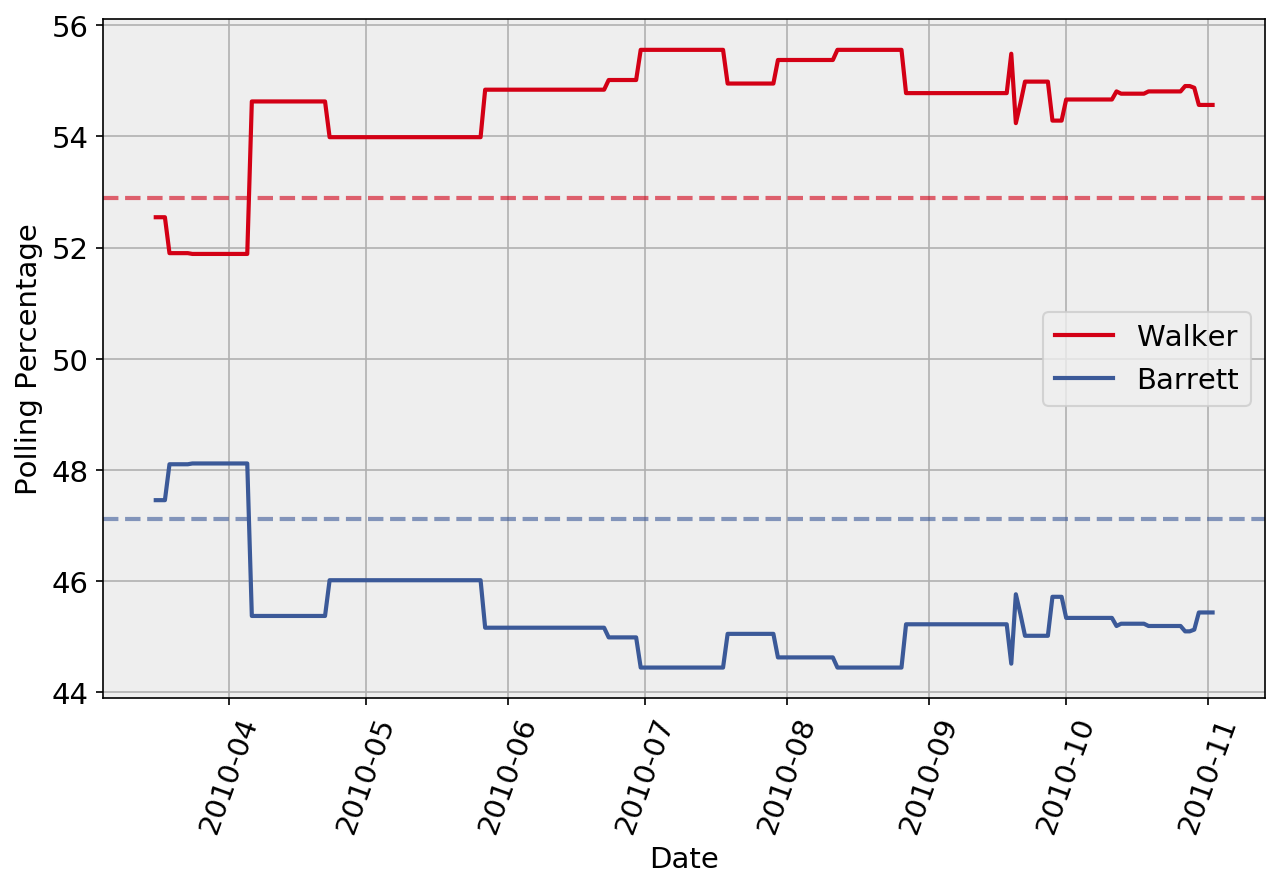

http://www.realclearpolitics.com/epolls/2010/governor/ia/iowa_governor_branstad_vs_culver-1200.html


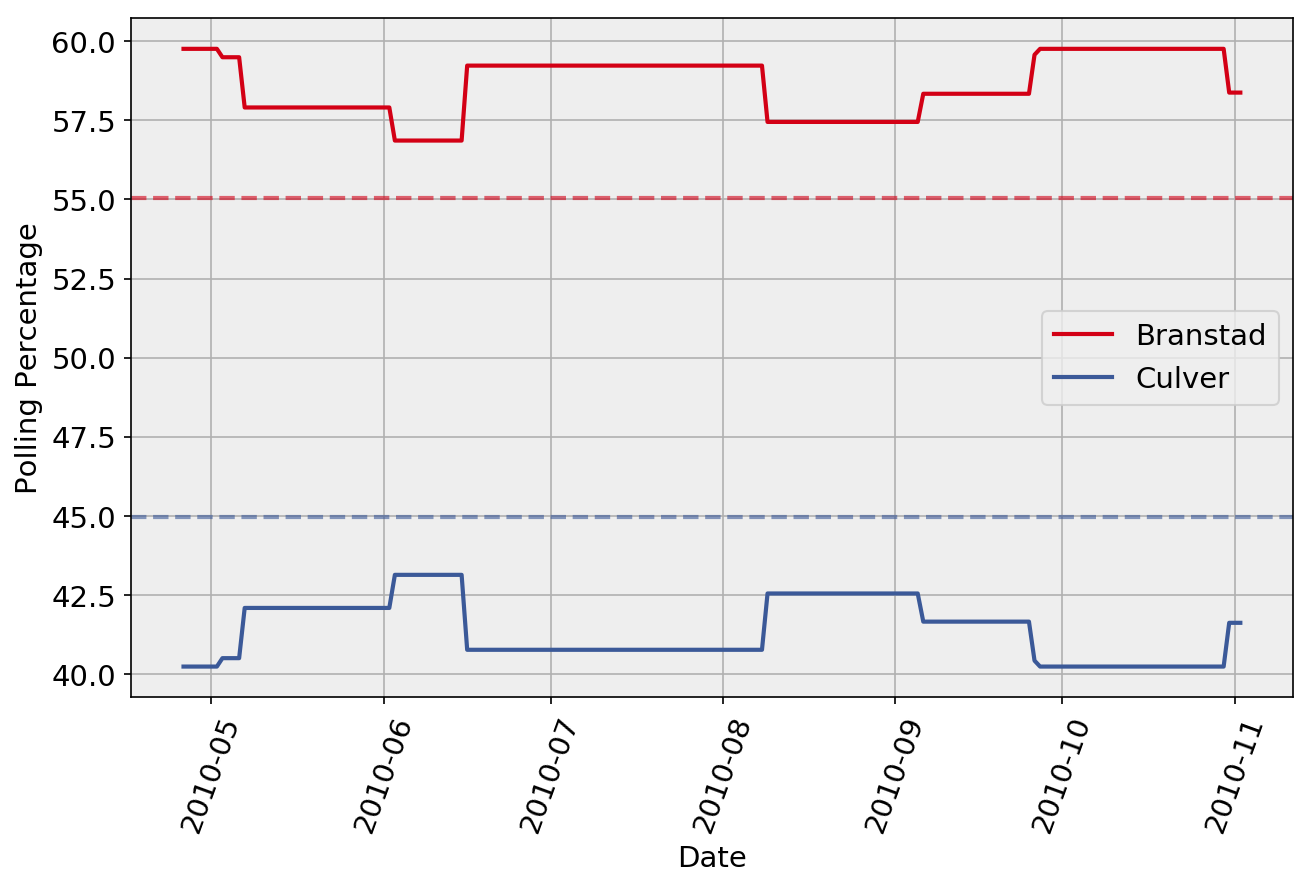

http://www.realclearpolitics.com/epolls/2010/governor/me/maine_governor_lepage_vs_mitchell_vs_cutler-1231.html


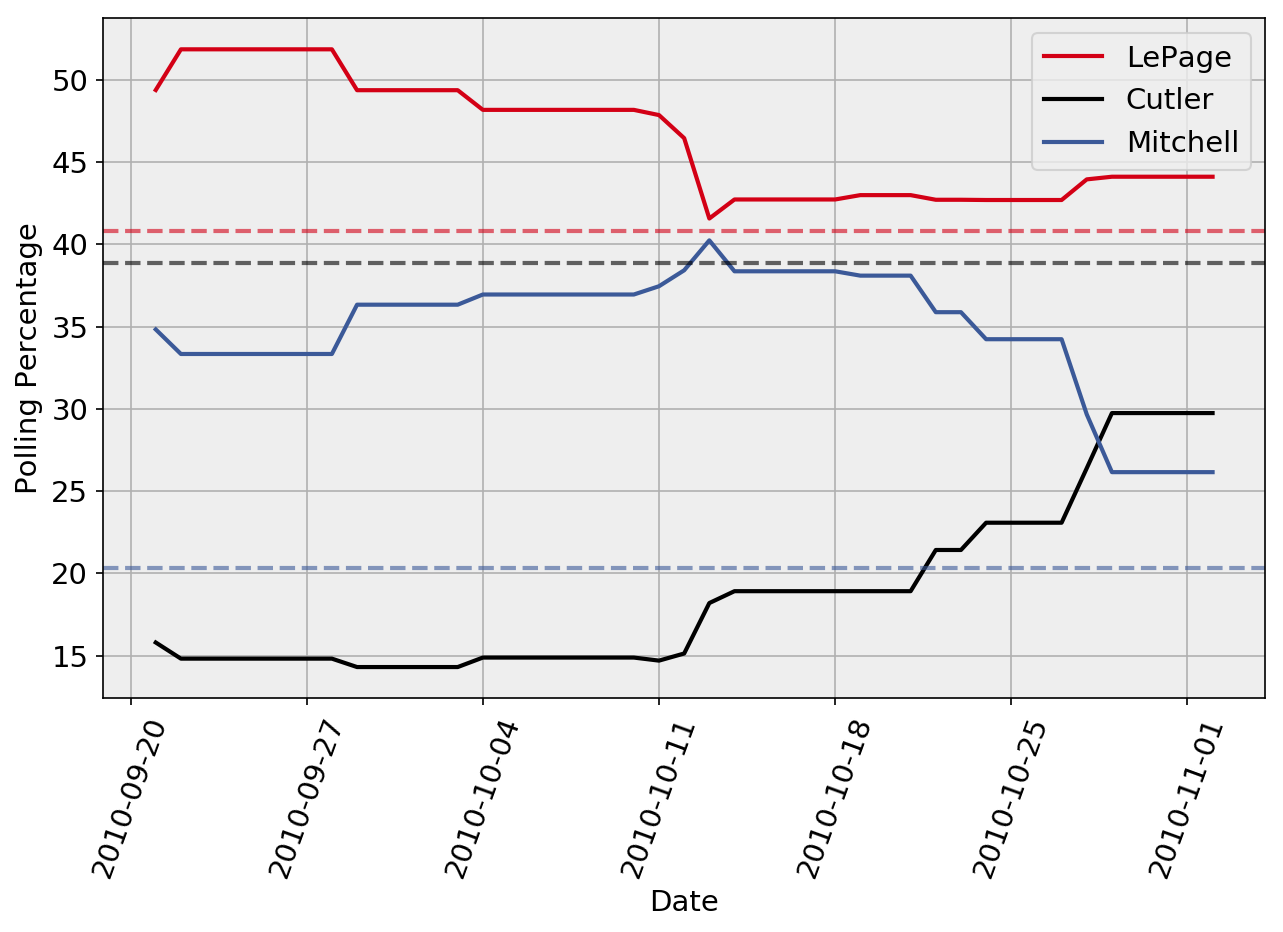

http://www.realclearpolitics.com/epolls/2010/governor/mi/michigan_governor_snyder_vs_bernero-1407.html


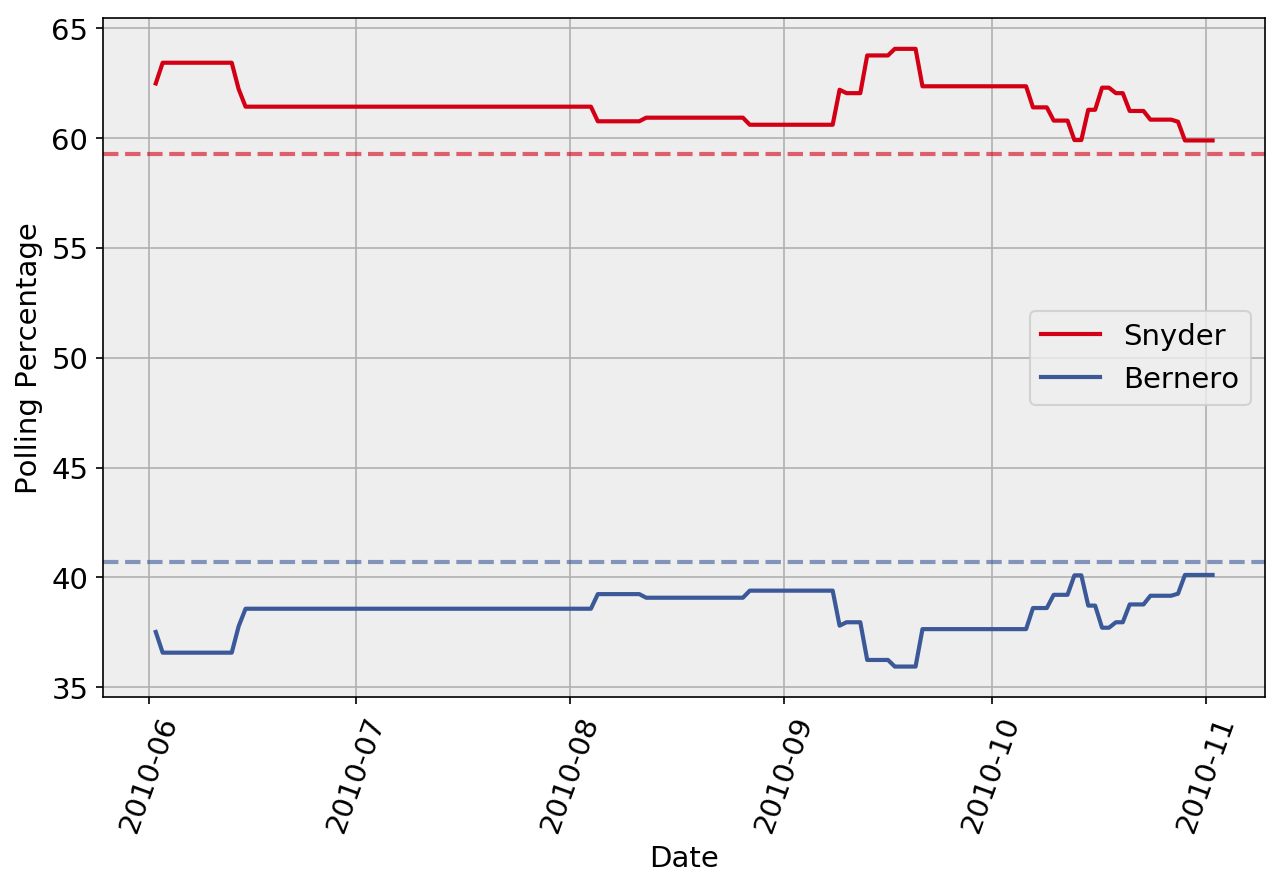

http://www.realclearpolitics.com/epolls/2010/governor/ks/kansas_governor_brownback_vs_holland-1235.html
http://www.realclearpolitics.com/epolls/2010/governor/ok/oklahoma_governor_fallin_vs_askins-1236.html
http://www.realclearpolitics.com/epolls/2010/governor/tn/tennessee_governor_haslam_vs_mcwherter-1416.html
http://www.realclearpolitics.com/epolls/2010/governor/wy/wyoming_governor_mead_vs_peterson-1627.html
http://www.realclearpolitics.com/epolls/2010/governor/co/colorado_governor_maes_vs_hickenlooper_vs_tancredo-1677.html


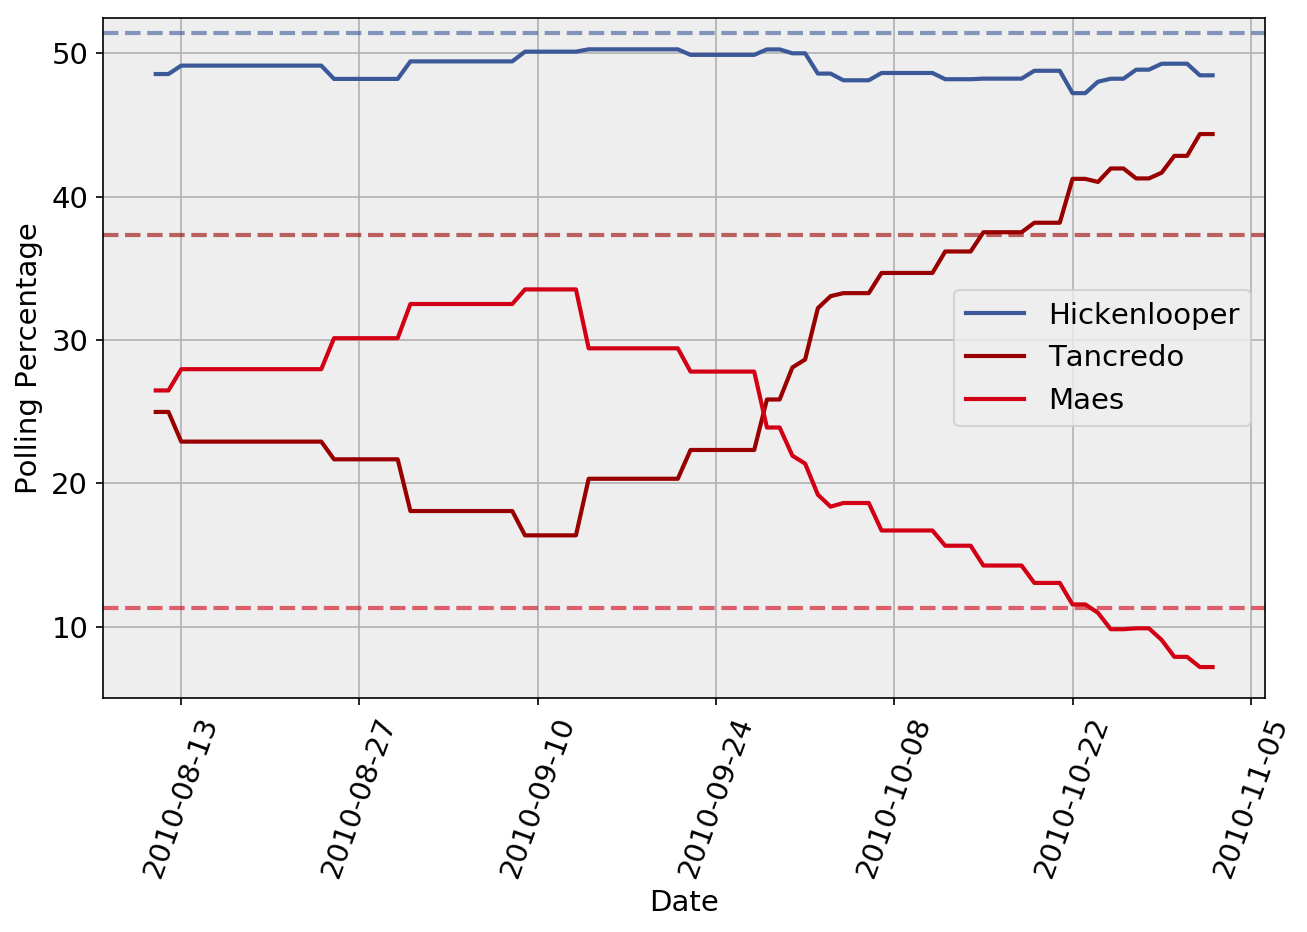

http://www.realclearpolitics.com/epolls/2010/governor/az/arizona_governor_brewer_vs_goddard-1409.html


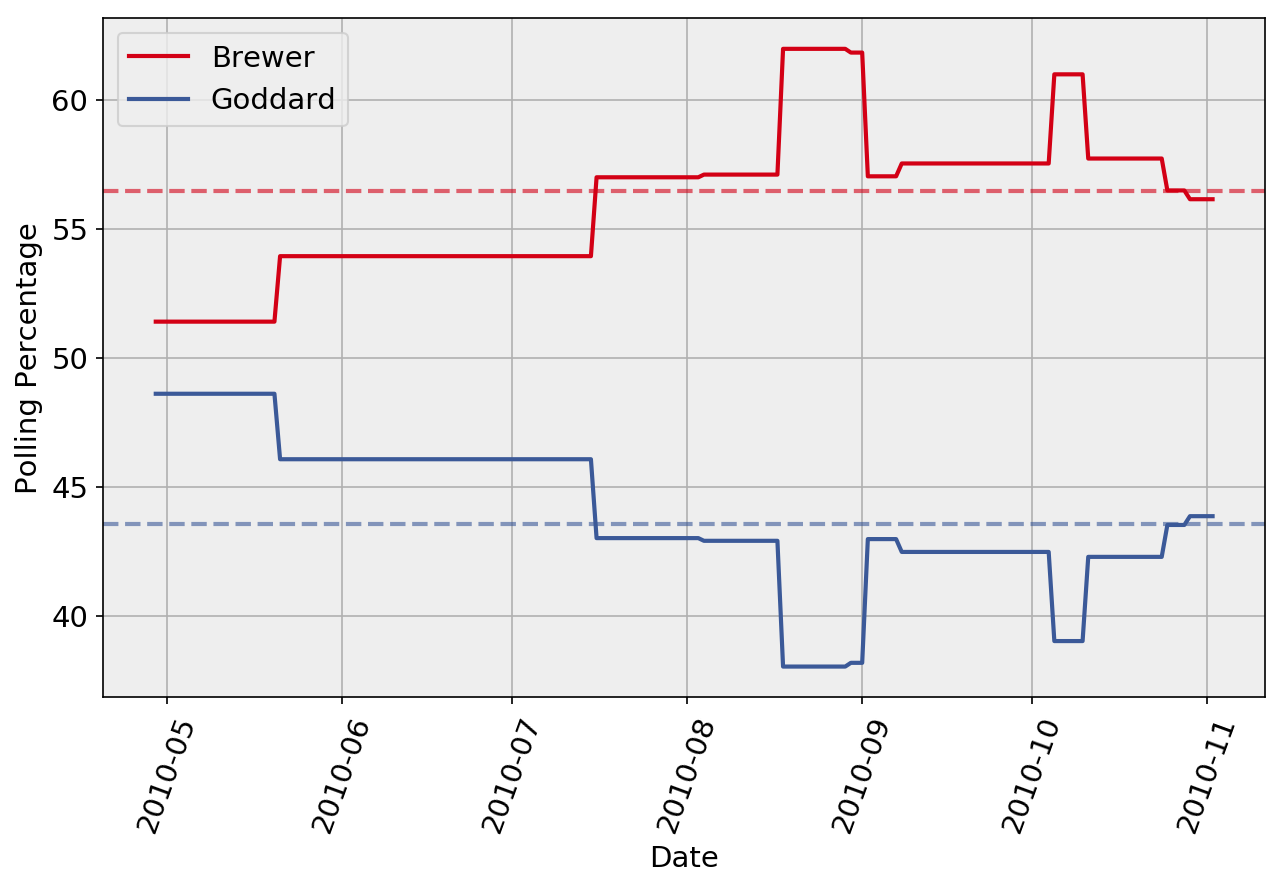

http://www.realclearpolitics.com/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html


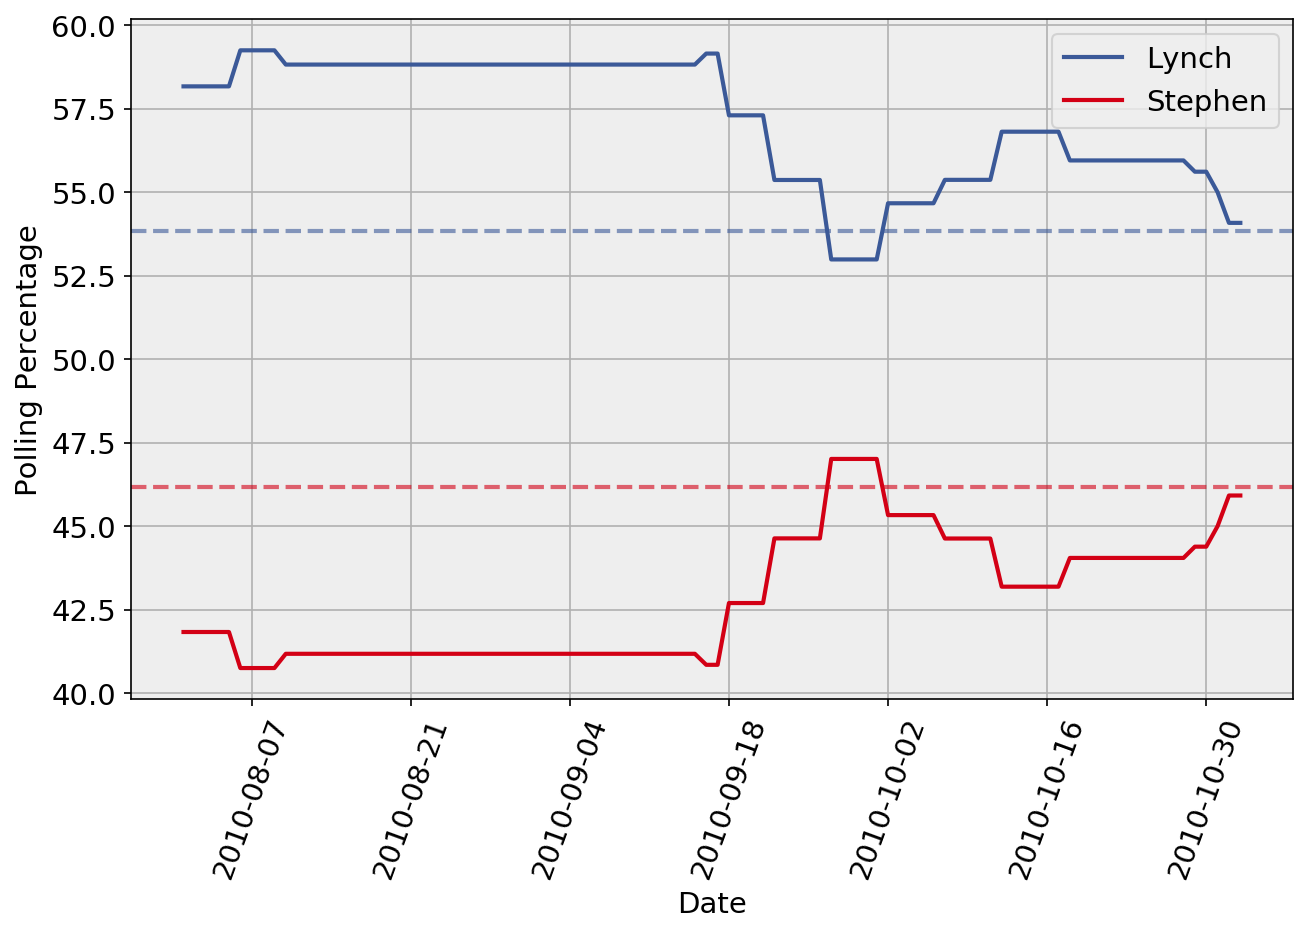

http://www.realclearpolitics.com/epolls/2010/governor/mn/minnesota_governor_emmer_vs_dayton_vs_horner-1393.html


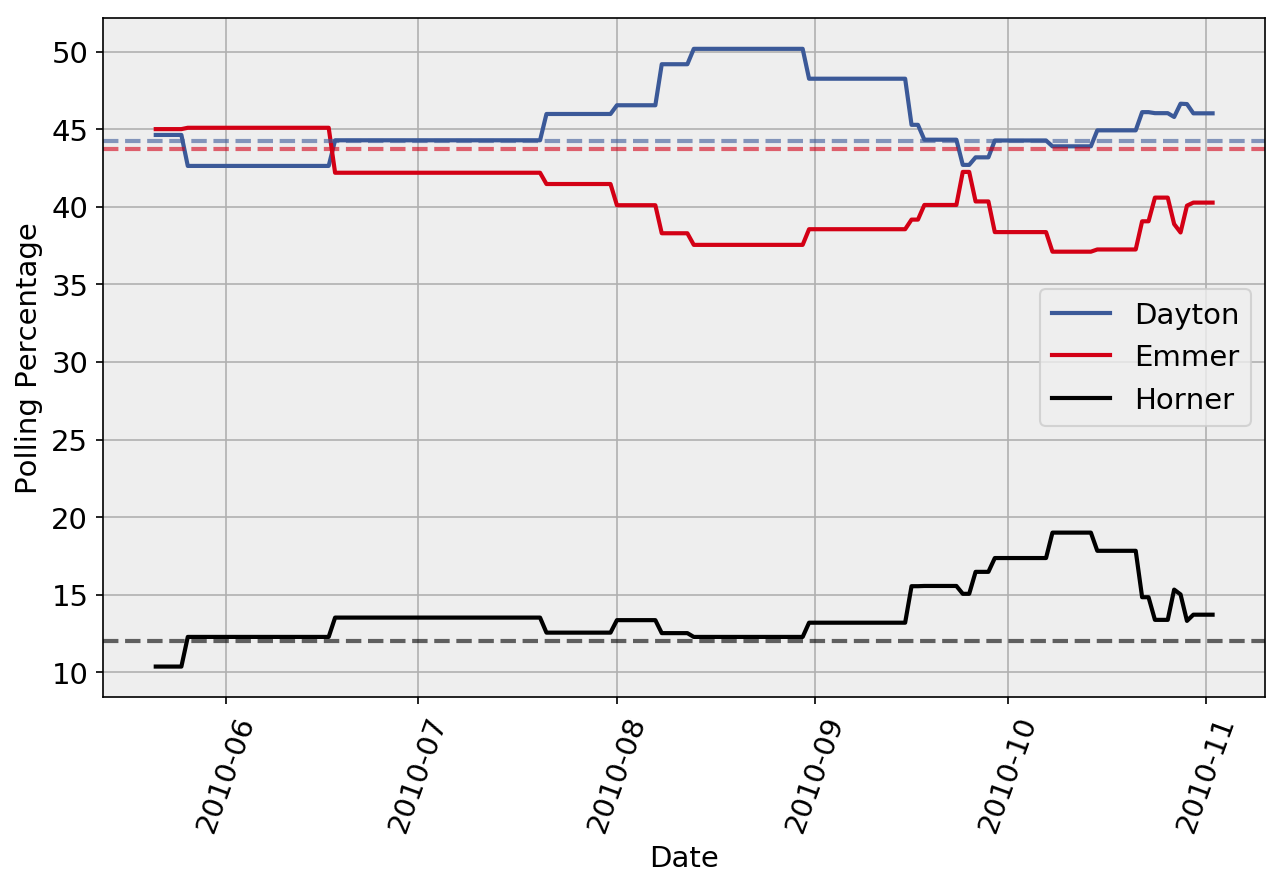

http://www.realclearpolitics.com/epolls/2010/governor/me/maine_governor_lepage_vs_mitchell_vs_cutler-1231.html


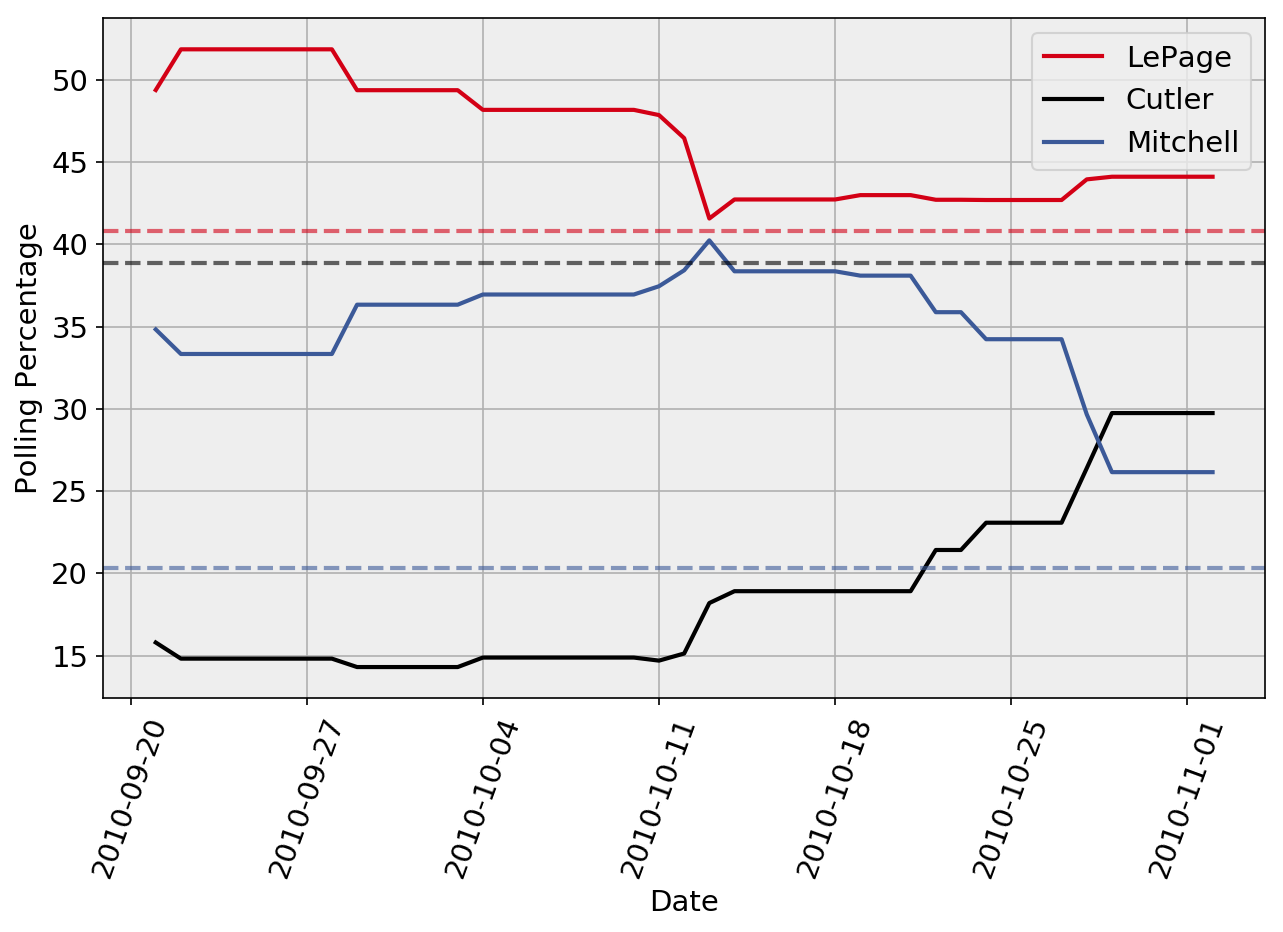

http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html


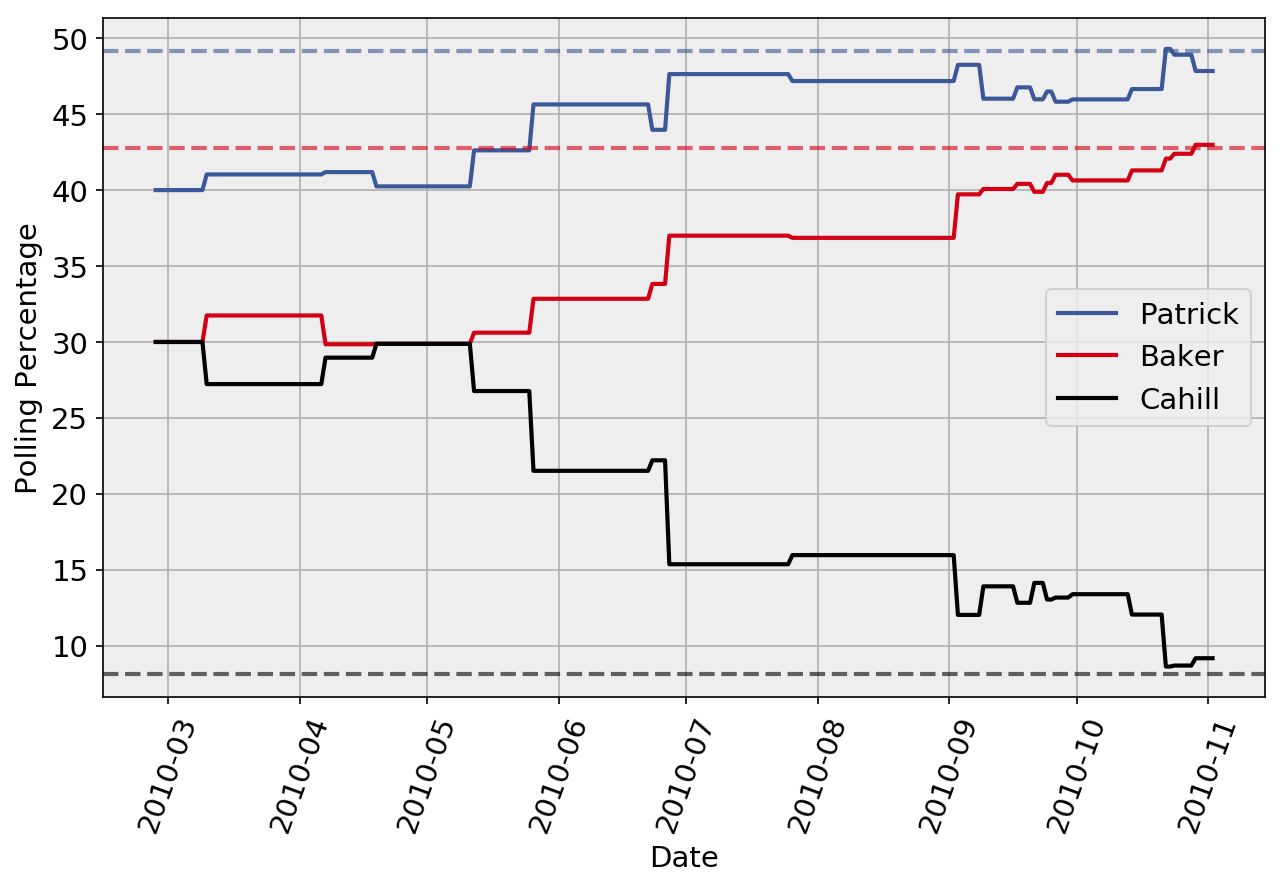

http://www.realclearpolitics.com/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html


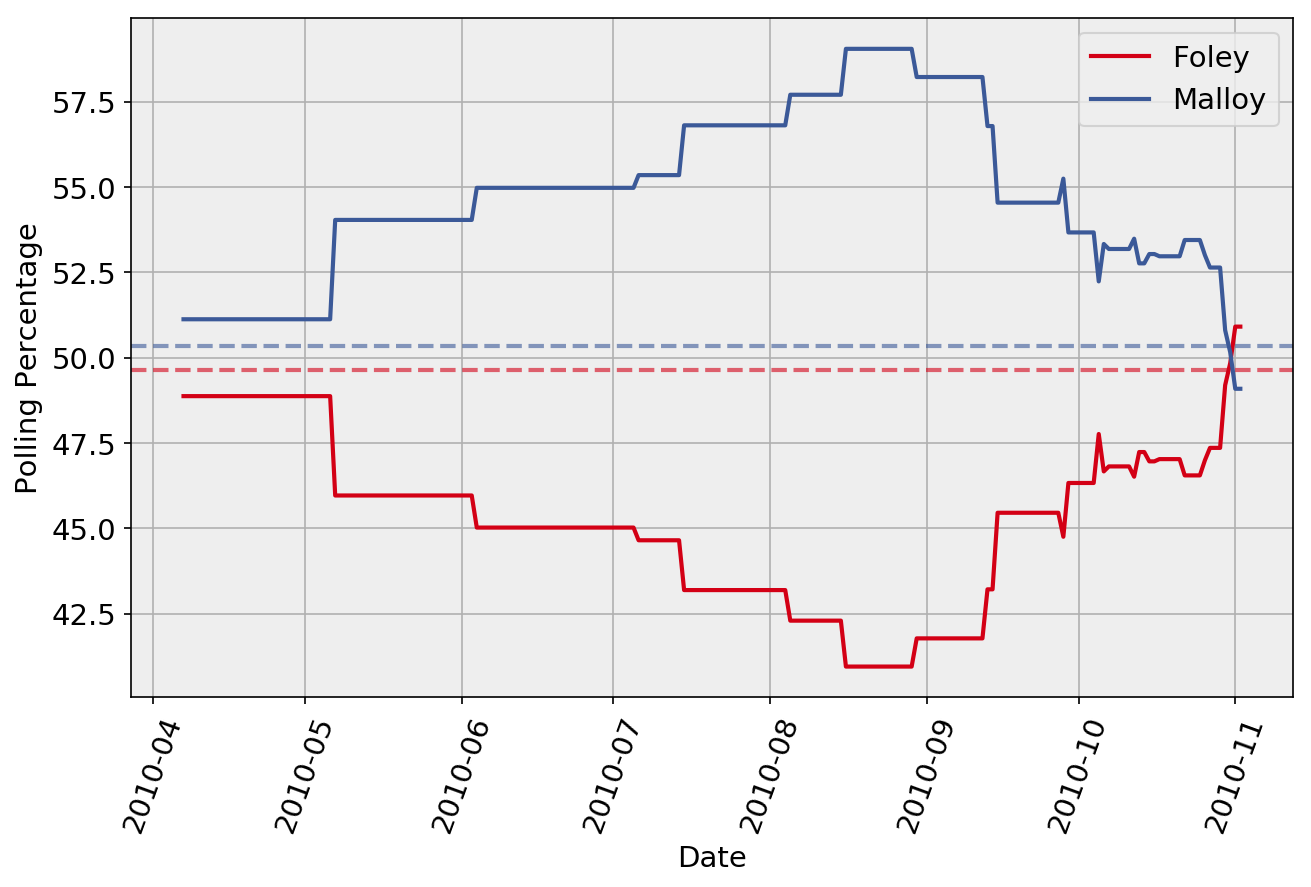

http://www.realclearpolitics.com/epolls/2010/governor/mn/minnesota_governor_emmer_vs_dayton_vs_horner-1393.html


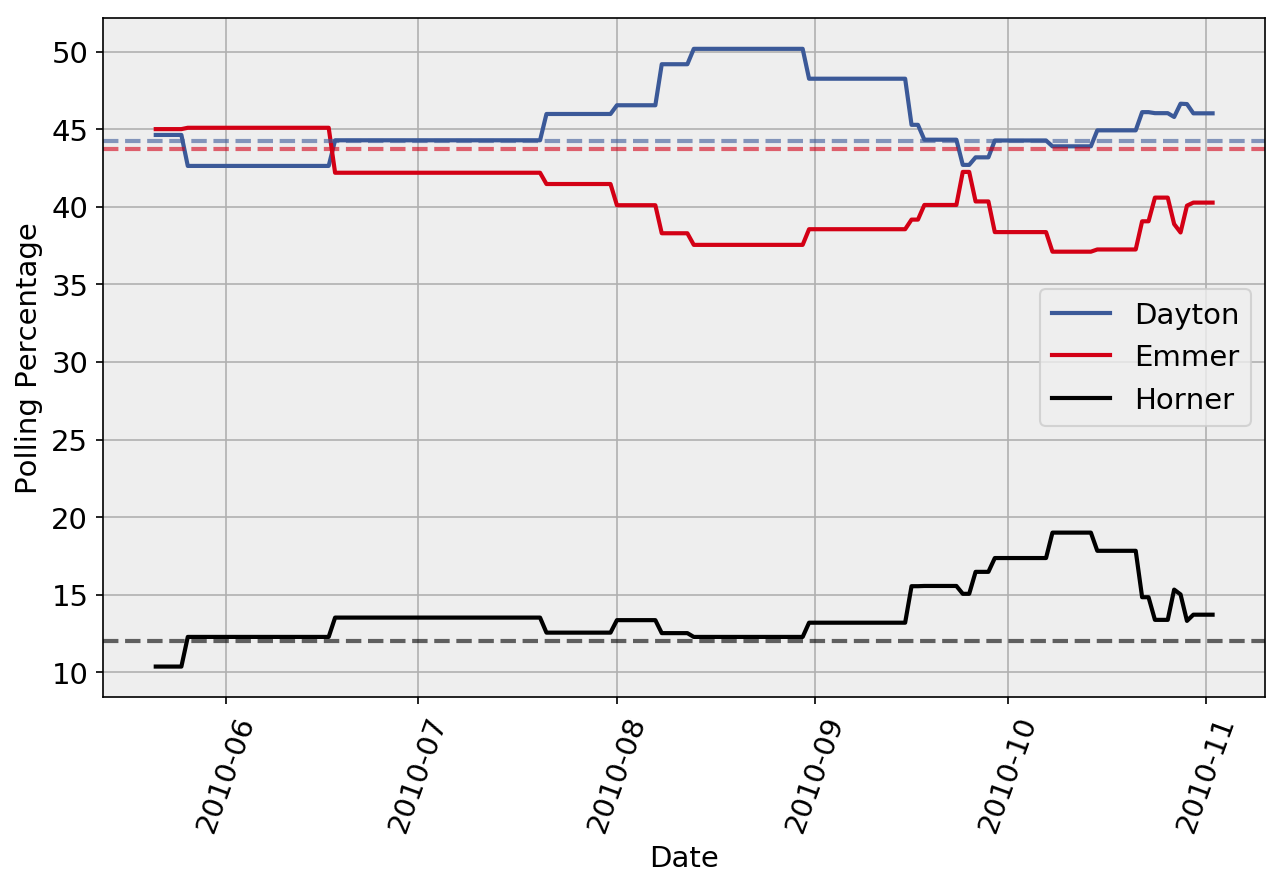

http://www.realclearpolitics.com/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html


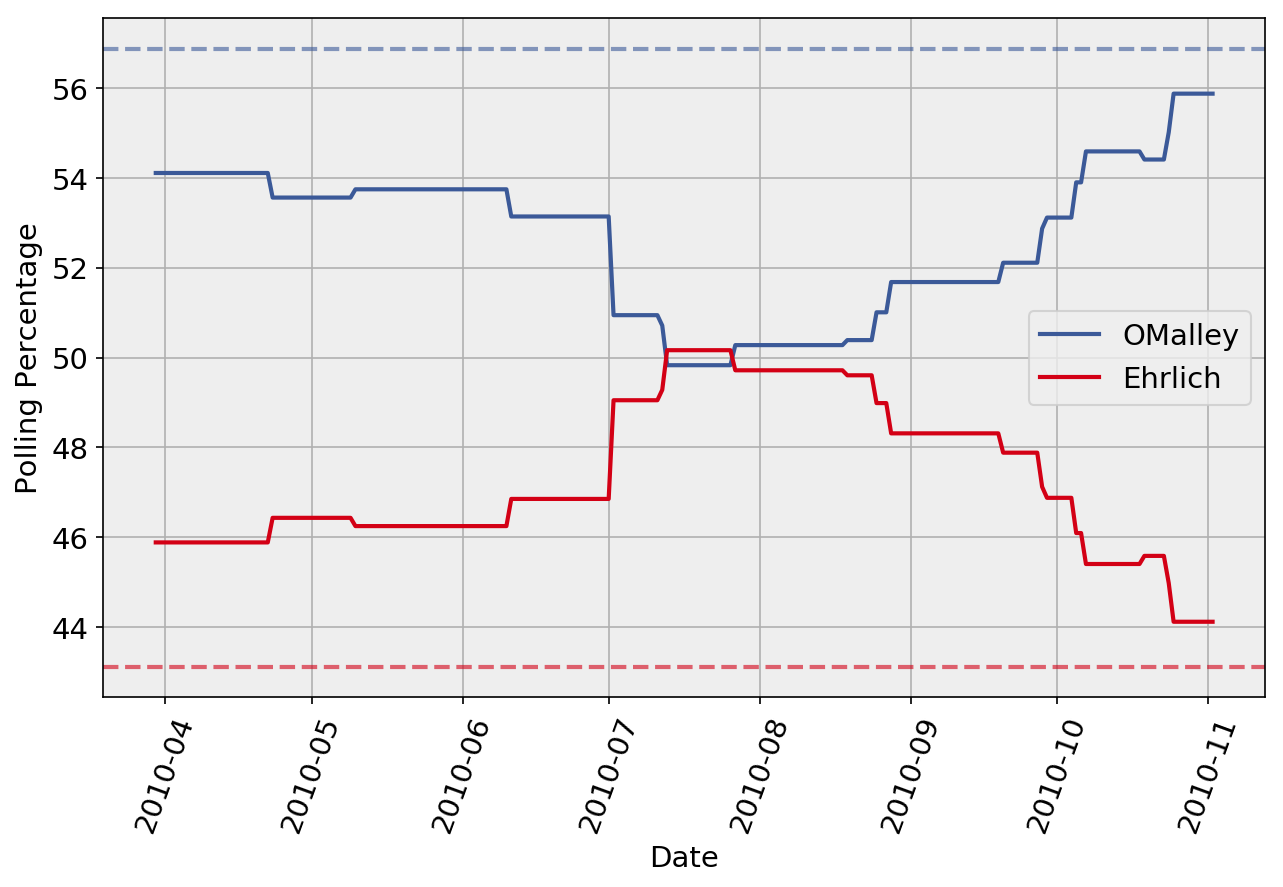

http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html


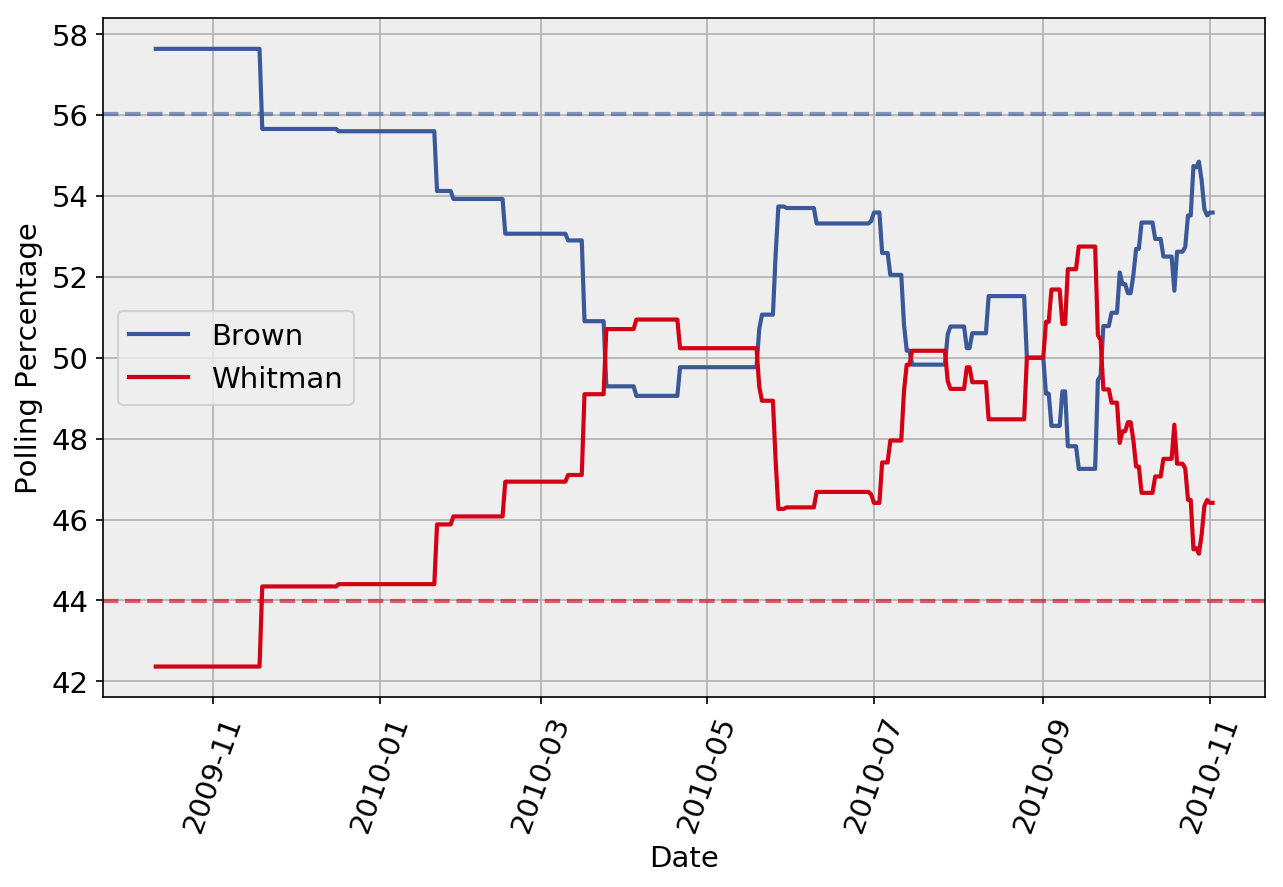

http://www.realclearpolitics.com/epolls/2010/governor/al/alabama_governor_bentley_vs_sparks-1586.html
http://www.realclearpolitics.com/epolls/2010/governor/id/idaho_governor_otter_vs_allred-1429.html
http://www.realclearpolitics.com/epolls/2010/governor/ks/kansas_governor_brownback_vs_holland-1235.html
http://www.realclearpolitics.com/epolls/2010/governor/ne/nebraska_governor_heineman_vs_meister-1695.html
http://www.realclearpolitics.com/epolls/2010/governor/ok/oklahoma_governor_fallin_vs_askins-1236.html
http://www.realclearpolitics.com/epolls/2010/governor/sd/south_dakota_governor_daugaard_vs_heidepriem-1310.html
http://www.realclearpolitics.com/epolls/2010/governor/tn/tennessee_governor_haslam_vs_mcwherter-1416.html
http://www.realclearpolitics.com/epolls/2010/governor/ut/utah_governor_special_election_herbert_vs_corroon-1454.html
http://www.realclearpolitics.com/epolls/2010/governor/wy/wyoming_governor_mead_vs_peterson-1627.html


In [26]:
page = requests.get('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html').text.encode('ascii', 'ignore')

for race in find_governor_races(page):
    print(race)
    plot_race(race)
    plt.show()

Briefly summarize these graphs -- how accurate is the typical poll a day before the election? How often does a prediction one month before the election mispredict the actual winner?

**Your summary here**
- out of 45 governor races for which we had historical data, brown and whitman election winning trend started 1 month before, in 3 cases the winner is predicted wrong and a day before 1 case with incorrect prediction.
- the polling percentages are closer to actual value a day before than a month before
- except for sometimes where trend suggests close election, actual outcome and predicted outcome matches

---

## Part 3: Analysis

#### Problem 5

You are (finally!) in a position to do some quantitative analysis.

We have provided an `error_data` function that builds upon the functions you have written. It computes a new DataFrame with information about polling errors.

Use `error_data`, `find_governer_races`, and `pd.concat` to construct a Data Frame summarizing the forecast errors
from all the Governor races

**Hint** 

It's best to set `ignore_index=True` in `pd.concat`

In [27]:
#pd.DataFrame.resample?
#np.timedelta64?
np.hstack?

In [30]:
def party_from_color(color):
    if color in ['#0000CC', '#3B5998']:
        return 'democrat'
    if color in ['#FF0000', '#D30015']:
        return 'republican'
    return 'other'


def error_data(url):
    """
    Given a Governor race URL, download the poll data and race result,
    and construct a DataFrame with the following columns:
    
    candidate: Name of the candidate
    forecast_length: Number of days before the election
    percentage: The percent of poll votes a candidate has.
                Normalized to that the canddidate percentages add to 100%
    error: Difference between percentage and actual race result
    party: Political party of the candidate
    
    The data are resampled as necessary, to provide one data point per day
    """
    
    id = id_from_url(url)
    xml = get_poll_xml(id)
    
    colors = plot_colors(xml)
    if len(colors) == 0:
        return pd.DataFrame()
    
    df = rcp_poll_data(xml)
    result = race_result(url)
    
    #remove non-letter characters from columns
    # df = df.rename(columns={c: _strip(c) for c in df.columns})
    #for k, v in result.items():
      #  result[_strip(k)] = v
    
    candidates = [c for c in df.columns if c is not 'date']
        
    #turn into a timeseries...
    df.index = df.date
    df = df.resample('D',).mean()
    df = df.dropna()
     #compute forecast length in days
    #(assuming that last forecast happens on the day of the election, for simplicity)
    
    #forecast_length = (df.date.max() - df.date).values commented as resample drops non numeric column#
    #forecast_length = forecast_length / np.timedelta64(1, 'D')  # convert to number of days
    forecast_length = (df.index.max() - df.index).values
    forecast_length = forecast_length / np.timedelta64(1, 'D')  # convert to number of days
    #...so that we can resample at regular, daily intervals
    #print(forecast_length)
    #compute forecast error
    errors = {}
    normalized = {}
    poll_lead = {} 
    for c in candidates:
        #turn raw percentage into percentage of poll votes
        corr = df[c].values / df[candidates].sum(axis=1).values * 100.
        err = corr - result[_strip(c)]
        
        normalized[c] = corr
        errors[c] = err
        
    n = forecast_length.size
    result = {}
    result['percentage'] = np.hstack(normalized[c] for c in candidates)
    result['error'] = np.hstack(errors[c] for c in candidates)
    result['candidate'] = np.hstack(np.repeat(c, n) for c in candidates)
    result['party'] = np.hstack(np.repeat(party_from_color(colors[_strip(c)]), n) for c in candidates)
    result['forecast_length'] = np.hstack(forecast_length for _ in candidates)
    result = pd.DataFrame(result)
    return result

In [31]:
error_data('http://www.realclearpolitics.com/epolls/2009/governor/nj/new_jersey_governor_corzine_vs_christie-1051.html')

candidate      error  forecast_length       party  percentage
0    Christie   0.646679             49.0  republican   49.889868
1    Christie   0.646679             48.0  republican   49.889868
2    Christie   0.646679             47.0  republican   49.889868
3    Christie   0.646679             46.0  republican   49.889868
4    Christie   0.646679             45.0  republican   49.889868
5    Christie   0.646679             44.0  republican   49.889868
6    Christie   0.646679             43.0  republican   49.889868
7    Christie  -0.223581             42.0  republican   49.019608
8    Christie  -0.223581             41.0  republican   49.019608
9    Christie  -0.330145             40.0  republican   48.913043
10   Christie  -0.330145             39.0  republican   48.913043
11   Christie  -0.330145             38.0  republican   48.913043
12   Christie  -0.330145             37.0  republican   48.913043
13   Christie  -0.330145             36.0  republican   48.913043
14   Christie  -1.030838             35.0  republican   48.212351
15   Christie  -1.557505             34.0  republican   47.685684
16   Christie  -2.266947             33.0  republican   46.976242
17   Christie  -1.931361             32.0  republican   47.311828
18   Christie  -1.931361             31.0  republican   47.311828
19   Christie  -1.931361             30.0  republican   47.311828
20   Christie  -2.756702             29.0  republican   46.486486
21   Christie  -3.187752             28.0  republican   46.055437
22   Christie  -3.187752             27.0  republican   46.055437
23   Christie  -4.184740             26.0  republican   45.058448
24   Christie  -4.184740             25.0  republican   45.058448
25   Christie  -4.184740             24.0  republican   45.058448
26   Christie  -4.728421             23.0  republican   44.514768
27   Christie  -4.728421             22.0  republican   44.514768
28   Christie  -4.916572             21.0  republican   44.326617
29   Christie  -5.150362             20.0  republican   44.092827
..        ...        ...              ...         ...         ...
120   Daggett   4.417596             29.0       other   10.270270
121   Daggett   4.808307             28.0       other   10.660981
122   Daggett   4.808307             27.0       other   10.660981
123   Daggett   5.943288             26.0       other   11.795962
124   Daggett   5.943288             25.0       other   11.795962
125   Daggett   5.943288             24.0       other   11.795962
126   Daggett   6.383613             23.0       other   12.236287
127   Daggett   6.383613             22.0       other   12.236287
128   Daggett   6.660582             21.0       other   12.513256
129   Daggett   7.016524             20.0       other   12.869198
130   Daggett   7.706648             19.0       other   13.559322
131   Daggett   8.615411             18.0       other   14.468085
132   Daggett   8.615411             17.0       other   14.468085
133   Daggett   8.615411             16.0       other   14.468085
134   Daggett   8.615411             15.0       other   14.468085
135   Daggett   8.768457             14.0       other   14.621131
136   Daggett   9.201089             13.0       other   15.053763
137   Daggett  10.458627             12.0       other   16.311301
138   Daggett  10.458627             11.0       other   16.311301
139   Daggett  10.458627             10.0       other   16.311301
140   Daggett  10.458627              9.0       other   16.311301
141   Daggett  10.458627              8.0       other   16.311301
142   Daggett   9.792146              7.0       other   15.644820
143   Daggett   8.463795              6.0       other   14.316469
144   Daggett   5.306124              5.0       other   11.158798
145   Daggett   7.053937              4.0       other   12.906611
146   Daggett   7.053937              3.0       other   12.906611
147   Daggett   6.239860              2.0       other   12.092534
148   Daggett   5.140983              1.0   

In [32]:
#your code here
def all_error_data():
    """
function
---------
all_error_data

Calls error_data on all races from find_governer_races(page),
and concatenates into a single DataFrame

Parameters
-----------
None

Examples
--------
df = all_error_data()
"""
    data = [error_data(race_page) for race_page in find_governor_races(page)]
    return pd.concat(data, ignore_index=True)


In [33]:
errors = all_error_data()

In [34]:
errors.head()

candidate     error  forecast_length     party  percentage
0     Deeds  2.696177            167.0  democrat   43.937419
1     Deeds  1.633916            166.0  democrat   42.875158
2     Deeds  1.633916            165.0  democrat   42.875158
3     Deeds  1.633916            164.0  democrat   42.875158
4     Deeds  1.633916            163.0  democrat   42.875158

Here's a histogram of the error of every polling measurement in the data

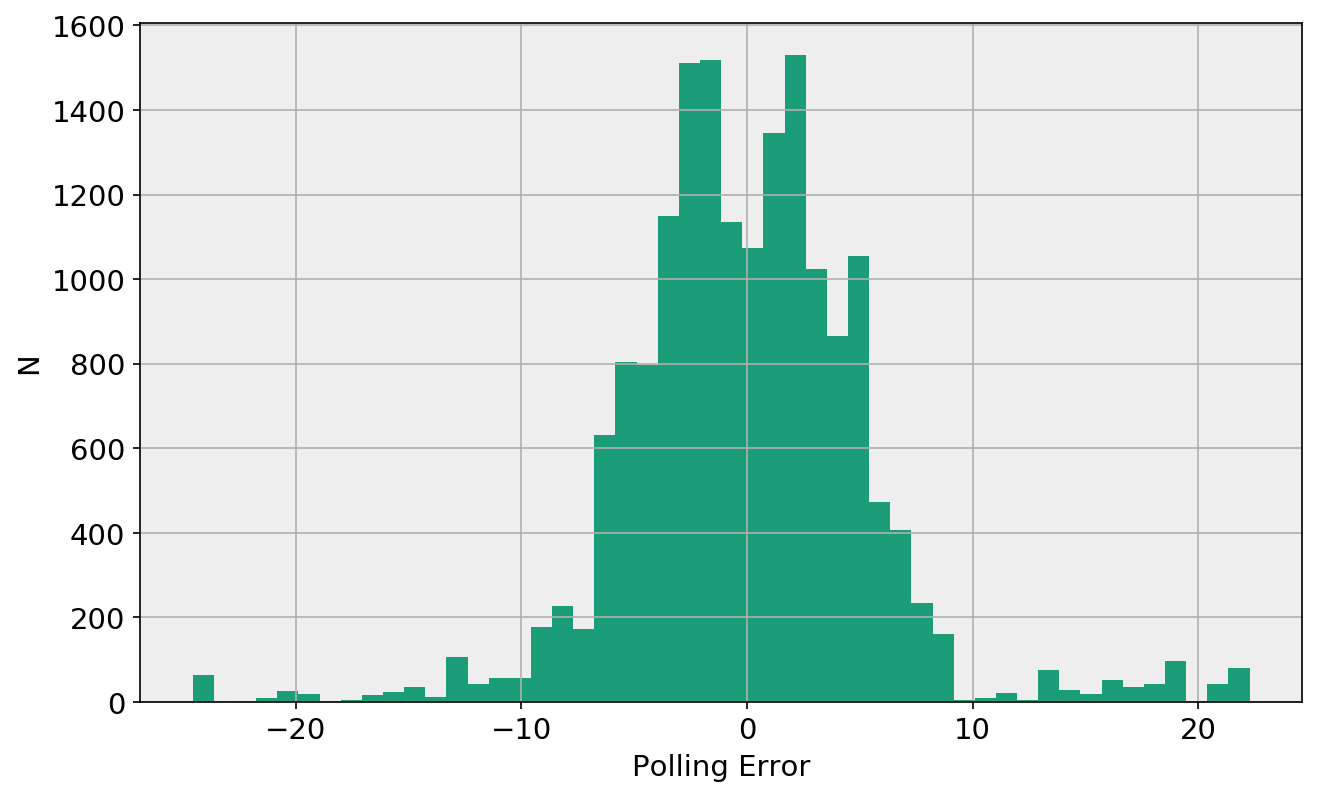

In [35]:
errors.error.hist(bins=50)
plt.xlabel("Polling Error")
plt.ylabel('N')

### Problem 6

Compute the standard deviation of the polling errors. How much uncertainty is there in the typical RCP poll?

In [36]:
#your code here
errors.error.std()

5.5190442383914675

### Problem 7

Repeat this calculation for the data where `errors.forecast_length < 7` (i.e. the polls within a week of an election). How much more/less accurate are they? How about the data where `errors.forecast_length > 30`? 

**Comment on this in 1 or 2 sentences**. Does this make sense?

In [38]:
#your code here
print(errors[errors.forecast_length < 7].error.std())
print(errors[errors.forecast_length > 30].error.std())
print('ratio of errors', errors[errors.forecast_length < 7].error.std()/errors[errors.forecast_length > 30].error.std())

3.474922711354242
5.517910994314374
ratio of errors 0.6297533097099217


- the errors before a week are less fluctuating than errors a month before,(better  by 37%)

### Problem 8

**Bootstrap resampling** is a general purpose way to use empirical data like the `errors` DataFrame to estimate uncertainties. For example, consider the [Viriginia Governor Race](http://www.realclearpolitics.com/epolls/2013/governor/va/virginia_governor_cuccinelli_vs_mcauliffe-3033.html). If we wanted to estimate how likey it is that McAuliffe will win given the current RCP data, the approch would be:

1. Pick a large number N of experiments to run (say N=1000).
2. For each experiment, randomly select a value from `errors.error`. We are assuming that these numbers represent a reasonable error distribution for the current poll data.
3. Assume that the error on McAullife's current polling score is given by this number (and, by extension, the error on Cuccinelli's poll score is the opposite). Calculate who actually wins the election in this simulation.
4. Repeat N times, and calculate the percentage of simulations where either candidate wins.

Bootstrapping isn't foolproof: it makes the assumption that the previous Governor race errors are representative of the Virginia race, and it does a bad job at estimating very rare events (with only ~30 races in the errors DataFrame, it would be hard to accurately predict probabilities for 1-in-a-million scenarios). Nevertheless, it's a versatile technique.

Use bootstrap resampling to estimate how likely it is that each candidate could win the following races.

 * [Virginia Governor](http://www.realclearpolitics.com/epolls/2013/governor/va/virginia_governor_cuccinelli_vs_mcauliffe-3033.html)
 * [New Jersey Governor](http://www.realclearpolitics.com/epolls/2013/governor/nj/new_jersey_governor_christie_vs_buono-3411.html)
 
**Summarize your results in a paragraph. What conclusions do you draw from the bootstrap analysis, and what assumptions did you make in reaching this conclusion. What are some limitations of this analysis?**
 

In [39]:
#your code here
def bootstrap_result(c1, c2, errors, nsample=1000):
    """
    Given the current polling data for 2 candidates, return the
    bootstrap-estimate for the win probability of each candidate
    
    Parameters
    ----------
    c1 : float
       The current proportion of poll votes for candidate 1
    c2 : float
       The current proportio of poll votes for candidate 2
    errors : DataFrame
       The errors DataFrame
    nsample : int
       The number of bootstrap iteraionts. Default=1000
       
    Returns
    -------
    p1, p2
    The probability that each candidate will win, based on the bootstrap simulations
    """
    #first, normalize votes to 100
    tot = (c1 + c2)
    c1 = 100* c1 / tot
    c2 = 100 * c2 / tot
    
    indices = np.random.randint(0, errors.shape[0], nsample)
    error = errors.iloc[indices].error.values
    
    #errors are symmetrical -- an overestimate for candidate 1 
    #is an underestimate for candidate 2
    c1_actual = c1 - error
    c2_actual = c2 + error
    
    p1 = (c1_actual > c2_actual).mean()
    p2 = 1 - p1
    return p1, p2
#virginia
nsample = 10000
mcauliffe, cuccinelli = 43.0, 39.0
pm, pc = bootstrap_result(mcauliffe, cuccinelli, errors, nsample=nsample)
print("Virginia Race")
print("-------------------------")
print("P(McAuliffe wins)  = %0.2f" % pm)
print("P(Cuccinelli wins) = %0.2f" % pc)

#new jersey
print("\n\n")
print("New Jersey Race")
print("-----------------------")
christie, buono = 55.4, 31.8
pc, pb = bootstrap_result(christie, buono, errors, nsample=nsample)
print("P(Christie wins) = %0.2f" % pc)
print("P(Buono wins)    = %0.2f" % pb)

Virginia Race
-------------------------
P(McAuliffe wins)  = 0.71
P(Cuccinelli wins) = 0.29



New Jersey Race
-----------------------
P(Christie wins) = 0.98
P(Buono wins)    = 0.02


**Your summary here**
*The Virginia race is currently fairly close. Our bootstrap simulations assume that historical RCP poll accuracies are representative of the uncertainty in the current polls. In 10,000 of these simulations, McCauliffe won 70% of the time.*

*The New Jersey race, on the other hand, is less close. In 10,000 simulations, a candidate enjoying a lead as big as Chris Christie wins about 98% of the time*

## Parting Thoughts

For comparison, most of the predictions in Nate Silver's [presidental forecast](http://fivethirtyeight.blogs.nytimes.com/fivethirtyeights-2012-forecast/) had confidences of >95%. This is more precise than what we can estimate from the RCP poll alone. His approach, however, is the same basic idea (albeit he used many more polls, and carefully calibrated each based on demographic and other information). Homework 2 will dive into some of his techniques further.


## How to submit

To submit your homework, create a folder named lastname_firstinitial_hw0 and place this notebook file in the folder. If your notebook requires any additional data files to run (it shouldn't), add them to this directory as well. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work.

---
*css tweaks in this cell*
<style>
div.text_cell_render {
    line-height: 150%;
    font-size: 110%;
    width: 800px;
    margin-left:50px;
    margin-right:auto;
    }
</style>